# 1. Import Modules and Load Data

In [180]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [2]:
CE = pd.read_csv('Dataset/CE.txt', header=None, sep='\t')            # Cooling Efficiency (virtual)
CP = pd.read_csv('Dataset/CP.txt', header=None, sep='\t')            # Cooling Power (virtual)
EPS1 = pd.read_csv('Dataset/EPS1.txt', header=None, sep='\t')        # Motor Power
FS1 = pd.read_csv('Dataset/FS1.txt', header=None, sep='\t')          # Volume Flow
FS2 = pd.read_csv('Dataset/FS2.txt', header=None, sep='\t')          # Volume Flow
PS1 = pd.read_csv('Dataset/PS1.txt', header=None, sep='\t')          # Pressure
PS2 = pd.read_csv('Dataset/PS2.txt', header=None, sep='\t')          # Pressure
PS3 = pd.read_csv('Dataset/PS3.txt', header=None, sep='\t')          # Pressure
PS4 = pd.read_csv('Dataset/PS4.txt', header=None, sep='\t')          # Pressure
PS5 = pd.read_csv('Dataset/PS5.txt', header=None, sep='\t')          # Pressure
PS6 = pd.read_csv('Dataset/PS6.txt', header=None, sep='\t')          # Pressure
SE = pd.read_csv('Dataset/SE.txt', header=None, sep='\t')            # Efficiency Factor
TS1 = pd.read_csv('Dataset/TS1.txt', header=None, sep='\t')          # Temperature
TS2 = pd.read_csv('Dataset/TS2.txt', header=None, sep='\t')          # Temperature
TS3 = pd.read_csv('Dataset/TS3.txt', header=None, sep='\t')          # Temperature
TS4 = pd.read_csv('Dataset/TS4.txt', header=None, sep='\t')          # Temperature
VS1 = pd.read_csv('Dataset/VS1.txt', header=None, sep='\t')          # Vibration
profile = pd.read_csv('Dataset/profile.txt', header=None, sep='\t')  # Target Condition Values

In [3]:
profile.head()

0    1  2    3  4
0  3  100  0  130  1
1  3  100  0  130  1
2  3  100  0  130  1
3  3  100  0  130  1
4  3  100  0  130  1

## Note: Fastest way to load a .txt file

In [247]:
%timeit np.genfromtxt('Dataset/CE.txt')

73.9 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [248]:
%timeit np.loadtxt('Dataset/CE.txt')

60.8 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [249]:
%timeit pd.read_csv('Dataset/CE.txt', header=None, sep='\t')

10.8 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Is Pandas the fastest? No. The time indicated is per loop. Real pandas time per run is the indicated times 10. In conclusion, first part has to be updated.


# 2. EDA

Some extra definitions for easier understanding

In [3]:
# Dictionaries for each condition
cooler_condition = {3:'Close to total failure', 20:'Reduced Efficiency', 100:'Full Efficiency'}
valve_condition = {100:'Optimal switching behavior', 90:'Small lag', 80:'Severe lag', 73:'Close to total failure'}
internal_pump_leakage = {0:'No leakage', 1:'Weak leakage', 2:'Severe leakage'}
hydraulic_accumulator = {130:'Optimal pressure', 115:'Slightly reduced pressure', 100:'Severely reduced pressure',
                         90:'Close to total failure'}
stable_flag = {0:'Conditions were stable', 1:'Static conditions might not have been reached yet'}

# Conditions dictionaries
target_conditions_str = {0:'Cooler Condition', 1:'Valve Condition', 2:'Internal Pump Leakage',
                         3:'Hydraulic Accumulator', 4:'Stable Flag'}
target_conditions_dict = {0:cooler_condition, 1:valve_condition, 2:internal_pump_leakage,
                         3:hydraulic_accumulator, 4:stable_flag}

In [251]:
hydraulic_accumulator.values()

dict_values(['Optimal pressure', 'Slightly reduced pressure', 'Severely reduced pressure', 'Close to total failure'])

How many conditions to model? and How many samples per class on each condition?

In [30]:
for row in profile:
    unique_values = profile[row].unique()
    print(target_conditions_str[row])
    for label in unique_values:
        print('\t'+target_conditions_dict[row][label]+': '+str(sum(profile[row]==label)))
    #print('\n')

Cooler Condition
	Close to total failure: 732
	Reduced Efficiency: 732
	Full Efficiency: 741
Valve Condition
	Optimal switching behavior: 1125
	Close to total failure: 360
	Severe lag: 360
	Small lag: 360
Internal Pump Leakage
	No leakage: 1221
	Severe leakage: 492
	Weak leakage: 492
Hydraulic Accumulator
	Optimal pressure: 599
	Slightly reduced pressure: 399
	Severely reduced pressure: 399
	Close to total failure: 808
Stable Flag
	Static conditions might not have been reached yet: 756
	Conditions were stable: 1449


In [31]:
profile.head()

0    1  2    3  4
0  3  100  0  130  1
1  3  100  0  130  1
2  3  100  0  130  1
3  3  100  0  130  1
4  3  100  0  130  1

Overall, everything looks ok. There is some unbalance between classes. We'll see later if this affects posterior metrics. If it does, then some extra processing (undersampling, oversampling or maybe SMOTE) is required.

## 2.1 Feature Extraction

### 2.1.1 Statistical Features

Before any further exploration, we have to generate the features, since this is the core of this analysis. First, lets define the features that will be evaluated:

In [4]:
def crest_factor(x,k):
    s1 = k*np.max(x)/np.sum(np.sqrt(x**2))
    return s1

def shape_factor(x,k):
    s2 = np.sqrt((k)*(np.sum(x**2))*np.sum(np.abs(x)))
    return s2

def absolute_mean_amplitude(x,k):
    s3 = (1/k)*(np.sum(np.abs(x)))
    return s3

def square_root_amplitude(x,k):
    s4 = ((1/k)*np.sum(np.sqrt(np.abs(x))))**2
    return s4

def kurtosis(x,k):
    s5 = (1/k)*np.sum((x)**4)
    return s5

def variance_values(x,k):
    s6 = (1/k)*np.sum(x**2)
    return s6

def clearance_factor(x,k):
    s7 = (k**2)*np.max(x)/(np.sum(np.sqrt(x**2)))**2
    return s7

def impulse_indicator(x,k):
    s8 = k*np.max(np.abs(x))/np.sum(np.abs(x))
    return s8

def skewness_factor(x,k):
    s9 = (1/k)*np.sum((x)**3)
    return s9

def generate_features(X):
    if isinstance(X,pd.core.frame.DataFrame):
        features = pd.DataFrame()
        for i in range (len(X)):
            point = X.iloc[i,:]
            k = len(point)
            ftrs = pd.DataFrame([crest_factor(point,k), shape_factor(point,k),
            absolute_mean_amplitude(point,k), square_root_amplitude(point,k),
            kurtosis(point,k), variance_values(point,k), clearance_factor(point,k),
            impulse_indicator(point,k), skewness_factor(point,k)]).T
            features = pd.concat([features, ftrs],axis=0, ignore_index=True)
    else:
        features = []
        for point in X:
            k = len(point)
            ftrs = [crest_factor(point,k), shape_factor(point,k),
            absolute_mean_amplitude(point,k), square_root_amplitude(point,k),
            kurtosis(point,k), variance_values(point,k), clearance_factor(point,k),
            impulse_indicator(point,k), skewness_factor(point,k)]
            features.append(ftrs)
    return features

Now we generate the features. (Note: This will take some time, even more if we're working with DataFrames as input)

In [5]:
features_CE = generate_features(CE)
features_CP = generate_features(CP)
features_SE = generate_features(SE)
features_PS1 = generate_features(PS1)
features_PS2 = generate_features(PS2)
features_PS3 = generate_features(PS3)
features_PS4 = generate_features(PS4+0.01)
features_PS5 = generate_features(PS5)
features_PS6 = generate_features(PS6)
features_EPS1 = generate_features(EPS1)
features_FS1 = generate_features(FS1)
features_FS2 = generate_features(FS2)
features_TS1 = generate_features(TS1)
features_TS2 = generate_features(TS2)
features_TS3 = generate_features(TS3)
features_TS4 = generate_features(TS4)
features_VS1 = generate_features(VS1)

KeyboardInterrupt: 

Since feature generation takes too much time, it's better to save the generated DataFrames in txt files.

#### 2.1.1.1 Saving the Generated Features (Optional)

Note: Only run this section if you want to generate .txt files with the generated features and skip the process of generating them again.

In [5]:
try:
    os.makedirs('Features')
except:
    pass

features_CE.to_csv('Features/CE.txt', index=False, header=None)
features_CP.to_csv('Features/CP.txt', index=False, header=None)
features_SE.to_csv('Features/SE.txt', index=False, header=None)
features_PS1.to_csv('Features/PS1.txt', index=False, header=None)
features_PS2.to_csv('Features/PS2.txt', index=False, header=None)
features_PS3.to_csv('Features/PS3.txt', index=False, header=None)
features_PS4.to_csv('Features/PS4.txt', index=False, header=None)
features_PS5.to_csv('Features/PS5.txt', index=False, header=None)
features_PS6.to_csv('Features/PS6.txt', index=False, header=None)
features_EPS1.to_csv('Features/EPS1.txt', index=False, header=None)
features_FS1.to_csv('Features/FS1.txt', index=False, header=None)
features_FS2.to_csv('Features/FS2.txt', index=False, header=None)
features_TS1.to_csv('Features/TS1.txt', index=False, header=None)
features_TS2.to_csv('Features/TS2.txt', index=False, header=None)
features_TS3.to_csv('Features/TS3.txt', index=False, header=None)
features_TS4.to_csv('Features/TS4.txt', index=False, header=None)
features_VS1.to_csv('Features/VS1.txt', index=False, header=None)

NameError: name 'features_CE' is not defined

#### 2.2.1.2 Loading the Generated Features

In [5]:
features_dict={0:'CREST()',1:'SHAPE()',2:'MEAN()',3:'RMS()',4:'KURT()',5:'VAR()',6:'CLEAR()',7:'IMPULSE()',
               8:'SKEW()'}

In [6]:
def generate_header(name):
    header = []
    for i in range(9):
        header.append(name+'.'+features_dict[i])
    return header

In [7]:
features_CE_all = pd.read_csv('Features/CE.txt',header=None)
features_CE_all.columns=generate_header('CE')
features_CP_all = pd.read_csv('Features/CP.txt',header=None)
features_CP_all.columns=generate_header('CP')
features_SE_all = pd.read_csv('Features/SE.txt',header=None)
features_SE_all.columns=generate_header('SE')
features_PS1_all = pd.read_csv('Features/PS1.txt',header=None)
features_PS1_all.columns=generate_header('PS1')
features_PS2_all = pd.read_csv('Features/PS2.txt',header=None)
features_PS2_all.columns=generate_header('PS2')
features_PS3_all = pd.read_csv('Features/PS3.txt',header=None)
features_PS3_all.columns=generate_header('PS3')
features_PS4_all = pd.read_csv('Features/PS4.txt',header=None)
features_PS4_all.columns=generate_header('PS4')
features_PS5_all = pd.read_csv('Features/PS5.txt',header=None)
features_PS5_all.columns=generate_header('PS5')
features_PS6_all = pd.read_csv('Features/PS6.txt',header=None)
features_PS6_all.columns=generate_header('PS6')
features_EPS1_all = pd.read_csv('Features/EPS1.txt',header=None)
features_EPS1_all.columns=generate_header('EPS1')
features_FS1_all = pd.read_csv('Features/FS1.txt',header=None)
features_FS1_all.columns=generate_header('FS1')
features_FS2_all = pd.read_csv('Features/FS2.txt',header=None)
features_FS2_all.columns=generate_header('FS2')
features_TS1_all = pd.read_csv('Features/TS1.txt',header=None)
features_TS1_all.columns=generate_header('TS1')
features_TS2_all = pd.read_csv('Features/TS2.txt',header=None)
features_TS2_all.columns=generate_header('TS2')
features_TS3_all = pd.read_csv('Features/TS3.txt',header=None)
features_TS3_all.columns=generate_header('TS3')
features_TS4_all = pd.read_csv('Features/TS4.txt',header=None)
features_TS4_all.columns=generate_header('TS4')
features_VS1_all = pd.read_csv('Features/VS1.txt',header=None)
features_VS1_all.columns=generate_header('VS1')
profile = pd.read_csv('Dataset/profile.txt', header=None, sep='\t')  # Target Condition Values
profile.columns=['Cooler Cond.','Valve Cond.','Pump Leakage','Accumulator','stable Flag']

#### 2.2.1.3 Feature Overview

In [8]:
features_CE_all.describe()

CE.CREST()     CE.SHAPE()    CE.MEAN()     CE.RMS()     CE.KURT()  \
count  2205.000000    2205.000000  2205.000000  2205.000000  2.205000e+03   
mean      1.020783   85487.778692    31.299077    31.298052  1.864514e+06   
std       0.011495   46778.012641    11.575330    11.575484  2.138880e+06   
min       1.004151   34190.563806    17.555983    17.555145  9.510501e+04   
25%       1.013671   41844.334784    20.084650    20.083603  1.629854e+05   
50%       1.019108   66634.464314    27.392533    27.391788  5.633977e+05   
75%       1.025203  148215.574688    46.677383    46.676996  4.747937e+06   
max       1.213652  154093.070485    47.903667    47.903496  5.266381e+06   

          CE.VAR()   CE.CLEAR()  CE.IMPULSE()      CE.SKEW()  
count  2205.000000  2205.000000   2205.000000    2205.000000  
mean   1113.680135     0.037198      1.020783   43967.817313  
std     789.904741     0.012763      0.011495   42686.068289  
min     308.271669     0.021057      1.004151    5414.097968  
25%     403.559661     0.021699      1.013671    8109.366765  
50%     750.432910     0.037333      1.019108   20560.770384  
75%    2178.850494     0.051153      1.025203  101709.808627  
max    2294.794024     0.059264      1.213652  109932.190152

Two things can be observed:<br>- Features 0 and 6 (crest factor and clearance factor) have a very low standard deviation, which indicates that they almost dont change.<br>- Features 2 and 3 (absolute mean amplitude and square root amplitude) are almost identical.<br>Lets see if this is a data issue, or a feature issue.

In [39]:
features_VS1_all.describe()

VS1.CREST()  VS1.SHAPE()   VS1.MEAN()    VS1.RMS()   VS1.KURT()  \
count  2205.000000  2205.000000  2205.000000  2205.000000  2205.000000   
mean      1.177245   224.828881     0.613315     0.612362     0.160281   
std       0.165624    34.283775     0.060260     0.059467     0.095051   
min       1.043127   176.579449     0.524367     0.524210     0.076154   
25%       1.098867   192.445140     0.555100     0.554856     0.096172   
50%       1.120640   221.826772     0.610183     0.609623     0.141065   
75%       1.157272   245.371827     0.649850     0.647687     0.190201   
max       3.034324   407.626420     0.839067     0.814113     2.494826   

         VS1.VAR()  VS1.CLEAR()  VS1.IMPULSE()   VS1.SKEW()  
count  2205.000000  2205.000000    2205.000000  2205.000000  
mean      0.382630     1.927052       1.177245     0.243946  
std       0.079964     0.233185       0.165624     0.085025  
min       0.275291     1.386400       1.043127     0.144702  
25%       0.308760     1.816430       1.098867     0.172133  
50%       0.373413     1.936770       1.120640     0.229367  
75%       0.428476     2.021768       1.157272     0.284394  
max       0.916800     3.616308       3.034324     1.351807

In [40]:
features_PS5_all.describe()

PS5.CREST()   PS5.SHAPE()   PS5.MEAN()    PS5.RMS()   PS5.KURT()  \
count  2205.000000  2.205000e+03  2205.000000  2205.000000  2205.000000   
mean      1.005978  1.291071e+07     9.163320     9.163306  7219.083448   
std       0.000890  1.218804e+06     0.576296     0.576297  1813.617170   
min       1.004424  1.124578e+07     8.365800     8.365786  4898.325610   
25%       1.005295  1.161360e+07     8.547239     8.547225  5337.280112   
50%       1.005986  1.279143e+07     9.115781     9.115766  6905.449232   
75%       1.006454  1.435518e+07     9.844351     9.844339  9392.079434   
max       1.017662  1.464963e+07     9.978510     9.978497  9914.632061   

         PS5.VAR()  PS5.CLEAR()  PS5.IMPULSE()   PS5.SKEW()  
count  2205.000000  2205.000000    2205.000000  2205.000000  
mean     84.298901     0.110220       1.005978   778.579582  
std      10.614193     0.006950       0.000890   146.982329  
min      69.987092     0.100743       1.004424   585.505972  
25%      73.055756     0.102094       1.005295   624.432975  
50%      83.097984     0.110364       1.005986   757.512570  
75%      96.911749     0.117766       1.006454   954.043075  
max      99.571196     0.120409       1.017662   993.582698

In [41]:
features_TS4_all.describe()

TS4.CREST()    TS4.SHAPE()   TS4.MEAN()    TS4.RMS()    TS4.KURT()  \
count  2205.000000    2205.000000  2205.000000  2205.000000  2.205000e+03   
mean      1.001827  122631.975851    40.735654    40.735626  3.419679e+06   
std       0.002103   36110.540558     8.107878     8.107878  2.425077e+06   
min       1.000268   77864.610396    30.390800    30.390799  8.530393e+05   
25%       1.000853   81277.913696    31.272567    31.272553  9.564421e+05   
50%       1.001565  119472.291747    40.429050    40.429049  2.671618e+06   
75%       1.002264  161414.913036    49.409500    49.409438  5.960119e+06   
max       1.058237  179631.671641    53.060417    53.060414  7.926533e+06   

         TS4.VAR()  TS4.CLEAR()  TS4.IMPULSE()     TS4.SKEW()  
count  2205.000000  2205.000000    2205.000000    2205.000000  
mean   1725.106004     0.025618       1.001827   75657.710385  
std     666.224666     0.005206       0.002103   42128.264892  
min     923.600897     0.018864       1.000268   28068.980640  
25%     977.975143     0.020294       1.000853   30583.900168  
50%    1634.508192     0.024767       1.001565   66081.622113  
75%    2441.310971     0.032037       1.002264  120625.167681  
max    2815.408488     0.033335       1.058237  149386.818772

First hypothesis isn't completelly true since the standard deviation of features 0 and 6 isn't close to 0. On the other hand, the second hypothesis is probably true. If it is, one of them has to be removed to avoid feature redundancy.

## 2.1.2 PCA

In [9]:
var_dict={0:CE,1:CP,2:EPS1,3:FS1,4:FS2,5:PS1,6:PS2,7:PS3,8:PS4,9:PS5,10:PS6,
          11:SE,12:VS1,13:TS1,14:TS2,15:TS3,16:TS4}
sens_dict={0:'CE',1:'CP',2:'EPS1',3:'FS1',4:'FS2',5:'PS1',6:'PS2',7:'PS3',8:'PS4',9:'PS5',10:'PS6',
          11:'SE',12:'VS1',13:'TS1',14:'TS2',15:'TS3',16:'TS4'}
pca_dict={}

In [10]:
def auto_label_gen(suffix, df):
    labels=[]
    for i in range(df.shape[1]):
        labels.append(suffix+str(i+1))
    return labels

In [11]:
from sklearn.decomposition import PCA

for j in range(17):
    
    x1,x2,_,_=train_test_split(var_dict[j],profile.iloc[:,3],shuffle=True, random_state=7, test_size=0.5)
    
    pca=PCA(n_components=20)
    pca.fit(x1)
    pca_dict[j]=pca.transform(var_dict[j])
    
    # Dimension choice
    n_components= len(pca.explained_variance_ratio_.cumsum()[pca.explained_variance_ratio_.cumsum()<0.995])
    pca_dict[j]= pca_dict[j][:,:n_components+1]
    #print(n_components+1)
    
    pca_dict[j]=pd.DataFrame(pca_dict[j])
    
    # Label generation
    suffix = sens_dict[j]+'.PCA_'
    pca_dict[j].columns=auto_label_gen(suffix,pca_dict[j])

In [12]:
PCA_all = pd.DataFrame()
for j in range(17):
    PCA_all = pd.concat([PCA_all, pca_dict[j]],axis=1)

### 2.1.3 Fourier Coefficients

In [13]:
def coefffourier(x,k):
    Y=np.fft.fft(x)
    Y=Y[:int(Y.shape[0]/2)]
    coef=abs(Y)
    E=np.mean(coef[1:-1]**2)
    coef2=(coef**2>=E)
    if(len(coef[coef2])>10):
        escogidos=np.flip(np.sort(coef[coef2]),axis=0)
        n=escogidos[:10]
    else:    
        escogidos=np.flip(np.sort(coef),axis=0)
        n=escogidos[:10]

    s1=n
    return s1

def generate_fourier_features(X):
    if isinstance(X,pd.core.frame.DataFrame):
        features = pd.DataFrame()
        for i in range (len(X)):
            point = X.iloc[i,:]
            k = len(point)
            ftrs = pd.DataFrame(coefffourier(point,k)).T
            features = pd.concat([features, ftrs],axis=0, ignore_index=True)
    else:
        features = []
        for point in X:
            k = len(point)
            ftrs = coefffourier(point,k)
            features.append(ftrs)
    return features

In [14]:
features_fourier_CE = generate_fourier_features(CE)
features_fourier_CP = generate_fourier_features(CP)
features_fourier_SE = generate_fourier_features(SE)
features_fourier_PS1 = generate_fourier_features(PS1)
features_fourier_PS2 = generate_fourier_features(PS2)
features_fourier_PS3 = generate_fourier_features(PS3)
features_fourier_PS4 = generate_fourier_features(PS4+0.01)
features_fourier_PS5 = generate_fourier_features(PS5)
features_fourier_PS6 = generate_fourier_features(PS6)
features_fourier_EPS1 = generate_fourier_features(EPS1)
features_fourier_FS1 =  generate_fourier_features(FS1)
features_fourier_FS2 = generate_fourier_features(FS2)
features_fourier_TS1 = generate_fourier_features(TS1)
features_fourier_TS2 = generate_fourier_features(TS2)
features_fourier_TS3 = generate_fourier_features(TS3)
features_fourier_TS4 = generate_fourier_features(TS4)
features_fourier_VS1 = generate_fourier_features(VS1)

In [15]:
features_dict={0:'FOURIER_1',1:'FOURIER_2',2:'FOURIER_3',3:'FOURIER_4',4:'FOURIER_5',5:'FOURIER_6',
               6:'FOURIER_7',7:'FOURIER_8',8:'FOURIER_9',9:'FOURIER_10'}

In [16]:
def generate_header(name):
    header = []
    for i in range(10):
        header.append(name+'.'+features_dict[i])
    return header

In [17]:
features_fourier_CE.columns=generate_header('CE')
features_fourier_CP.columns=generate_header('CP')
features_fourier_SE.columns=generate_header('SE')
features_fourier_PS1.columns=generate_header('PS1')
features_fourier_PS2.columns=generate_header('PS2')
features_fourier_PS3.columns=generate_header('PS3')
features_fourier_PS4.columns=generate_header('PS4')
features_fourier_PS5.columns=generate_header('PS5')
features_fourier_PS6.columns=generate_header('PS6')
features_fourier_EPS1.columns=generate_header('EPS1')
features_fourier_FS1.columns=generate_header('FS1')
features_fourier_FS2.columns=generate_header('FS2')
features_fourier_TS1.columns=generate_header('TS1')
features_fourier_TS2.columns=generate_header('TS2')
features_fourier_TS3.columns=generate_header('TS3')
features_fourier_TS4.columns=generate_header('TS4')
features_fourier_VS1.columns=generate_header('VS1')

In [18]:
all_features_fourier = pd.concat([features_fourier_CE,features_fourier_CP,features_fourier_SE,features_fourier_PS1,
                                  features_fourier_PS2,features_fourier_PS3,features_fourier_PS4,
                                  features_fourier_PS5,features_fourier_PS6,features_fourier_EPS1,
                                  features_fourier_FS1,features_fourier_FS2,features_fourier_TS1,
                                  features_fourier_TS2,features_fourier_TS3,features_fourier_TS4,
                                  features_fourier_VS1],axis=1)

### Statistical Features of the Derivative

In [19]:
def derivate(df):
    d = (df-df.shift(1,axis=1)).fillna(0)
    d = d*(60/d.shape[1])
    return d

In [22]:
def generate_header(name):
    header = []
    for i in range(9):
        header.append(name+'.d'+features_dict[i])
    return header

In [23]:
features_dict={0:'CREST()',1:'SHAPE()',2:'MEAN()',3:'RMS()',4:'KURT()',5:'VAR()',6:'CLEAR()',7:'IMPULSE()',
               8:'SKEW()'}

In [24]:
deriv_dict={}
for i in range(17):
    deriv_dict[i]=generate_features(derivate(var_dict[i]))
    
    #name='d'+sens_dict[i]+'.FOURIER_'
    deriv_dict[i].columns = generate_header(sens_dict[i])

In [25]:
deriv_all = pd.DataFrame()
for j in range(17):
    deriv_all = pd.concat([deriv_all, deriv_dict[j]],axis=1).fillna(0)

## 2.2 Feature analysis

In [26]:
# Dictionaries for each condition
cooler_condition = {3:'Close to total failure', 20:'Reduced Efficiency', 100:'Full Efficiency'}
valve_condition = {100:'Optimal switching behavior', 90:'Small lag', 80:'Severe lag', 73:'Close to total failure'}
internal_pump_leakage = {0:'No leakage', 1:'Weak leakage', 2:'Severe leakage'}
hydraulic_accumulator = {130:'Optimal pressure', 115:'Slightly reduced pressure', 100:'Severely reduced pressure',
                         90:'Close to total failure'}
stable_flag = {0:'Conditions were stable', 1:'Static conditions might not have been reached yet'}

# Conditions dictionaries
target_conditions_str = {0:'Cooler Cond.', 1:'Valve Cond.', 2:'Pump Leakage',
                         3:'Accumulator', 4:'stable Flag'}
target_conditions_dict = {0:cooler_condition, 1:valve_condition, 2:internal_pump_leakage,
                         3:hydraulic_accumulator, 4:stable_flag}

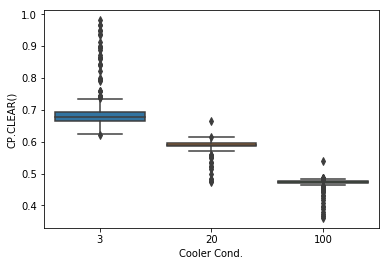

In [31]:
sns.boxplot(x=target_conditions_str[0],y='CP.CLEAR()',data=pd.concat([all_features,profile],axis=1))

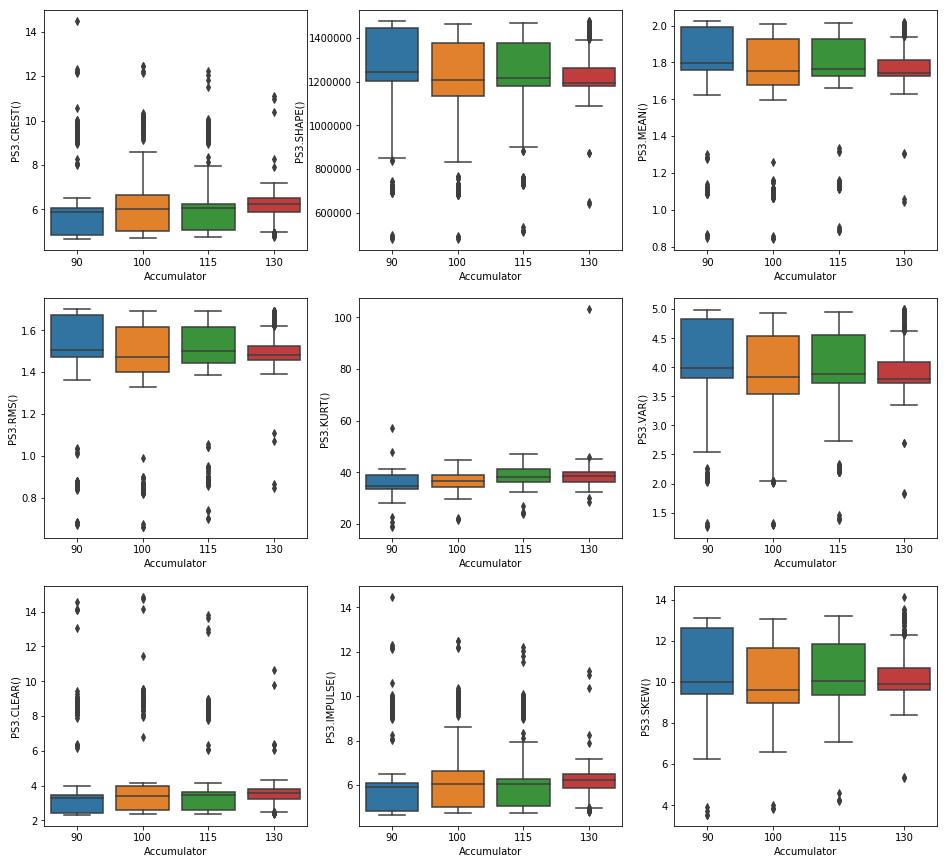

In [68]:
plt.figure(figsize=(16,15))
for x in range(9):
    plt.subplot(3,3,x+1)
    sns.boxplot(x=target_conditions_str[3],y=features_PS3_all.columns[x],data=pd.concat([features_PS3_all,profile],axis=1))

In [25]:
sens_dict={0:'PS1',1:'PS2',2:'PS3',3:'PS4',4:'PS5',5:'PS6',6:'EPS1',7:'FS1',8:'FS2',9:'TS1',10:'TS2',11:'TS3',
               12:'TS4',13:'VS1',14:'CE',15:'CP',16:'SE'}
sens_dict_inv={v: k for k, v in sens_dict.items()}
df_dict={0:features_PS1_all,1:features_PS2_all,2:features_PS3_all,3:features_PS4_all,4:features_PS5_all,
               5:features_PS6_all,6:features_EPS1_all,7:features_FS1_all,8:features_FS2_all,9:features_TS1_all,
               10:features_TS2_all,11:features_TS3_all,12:features_TS4_all,13:features_VS1_all,14:features_CE_all,
               15:features_CP_all,16:features_SE_all}

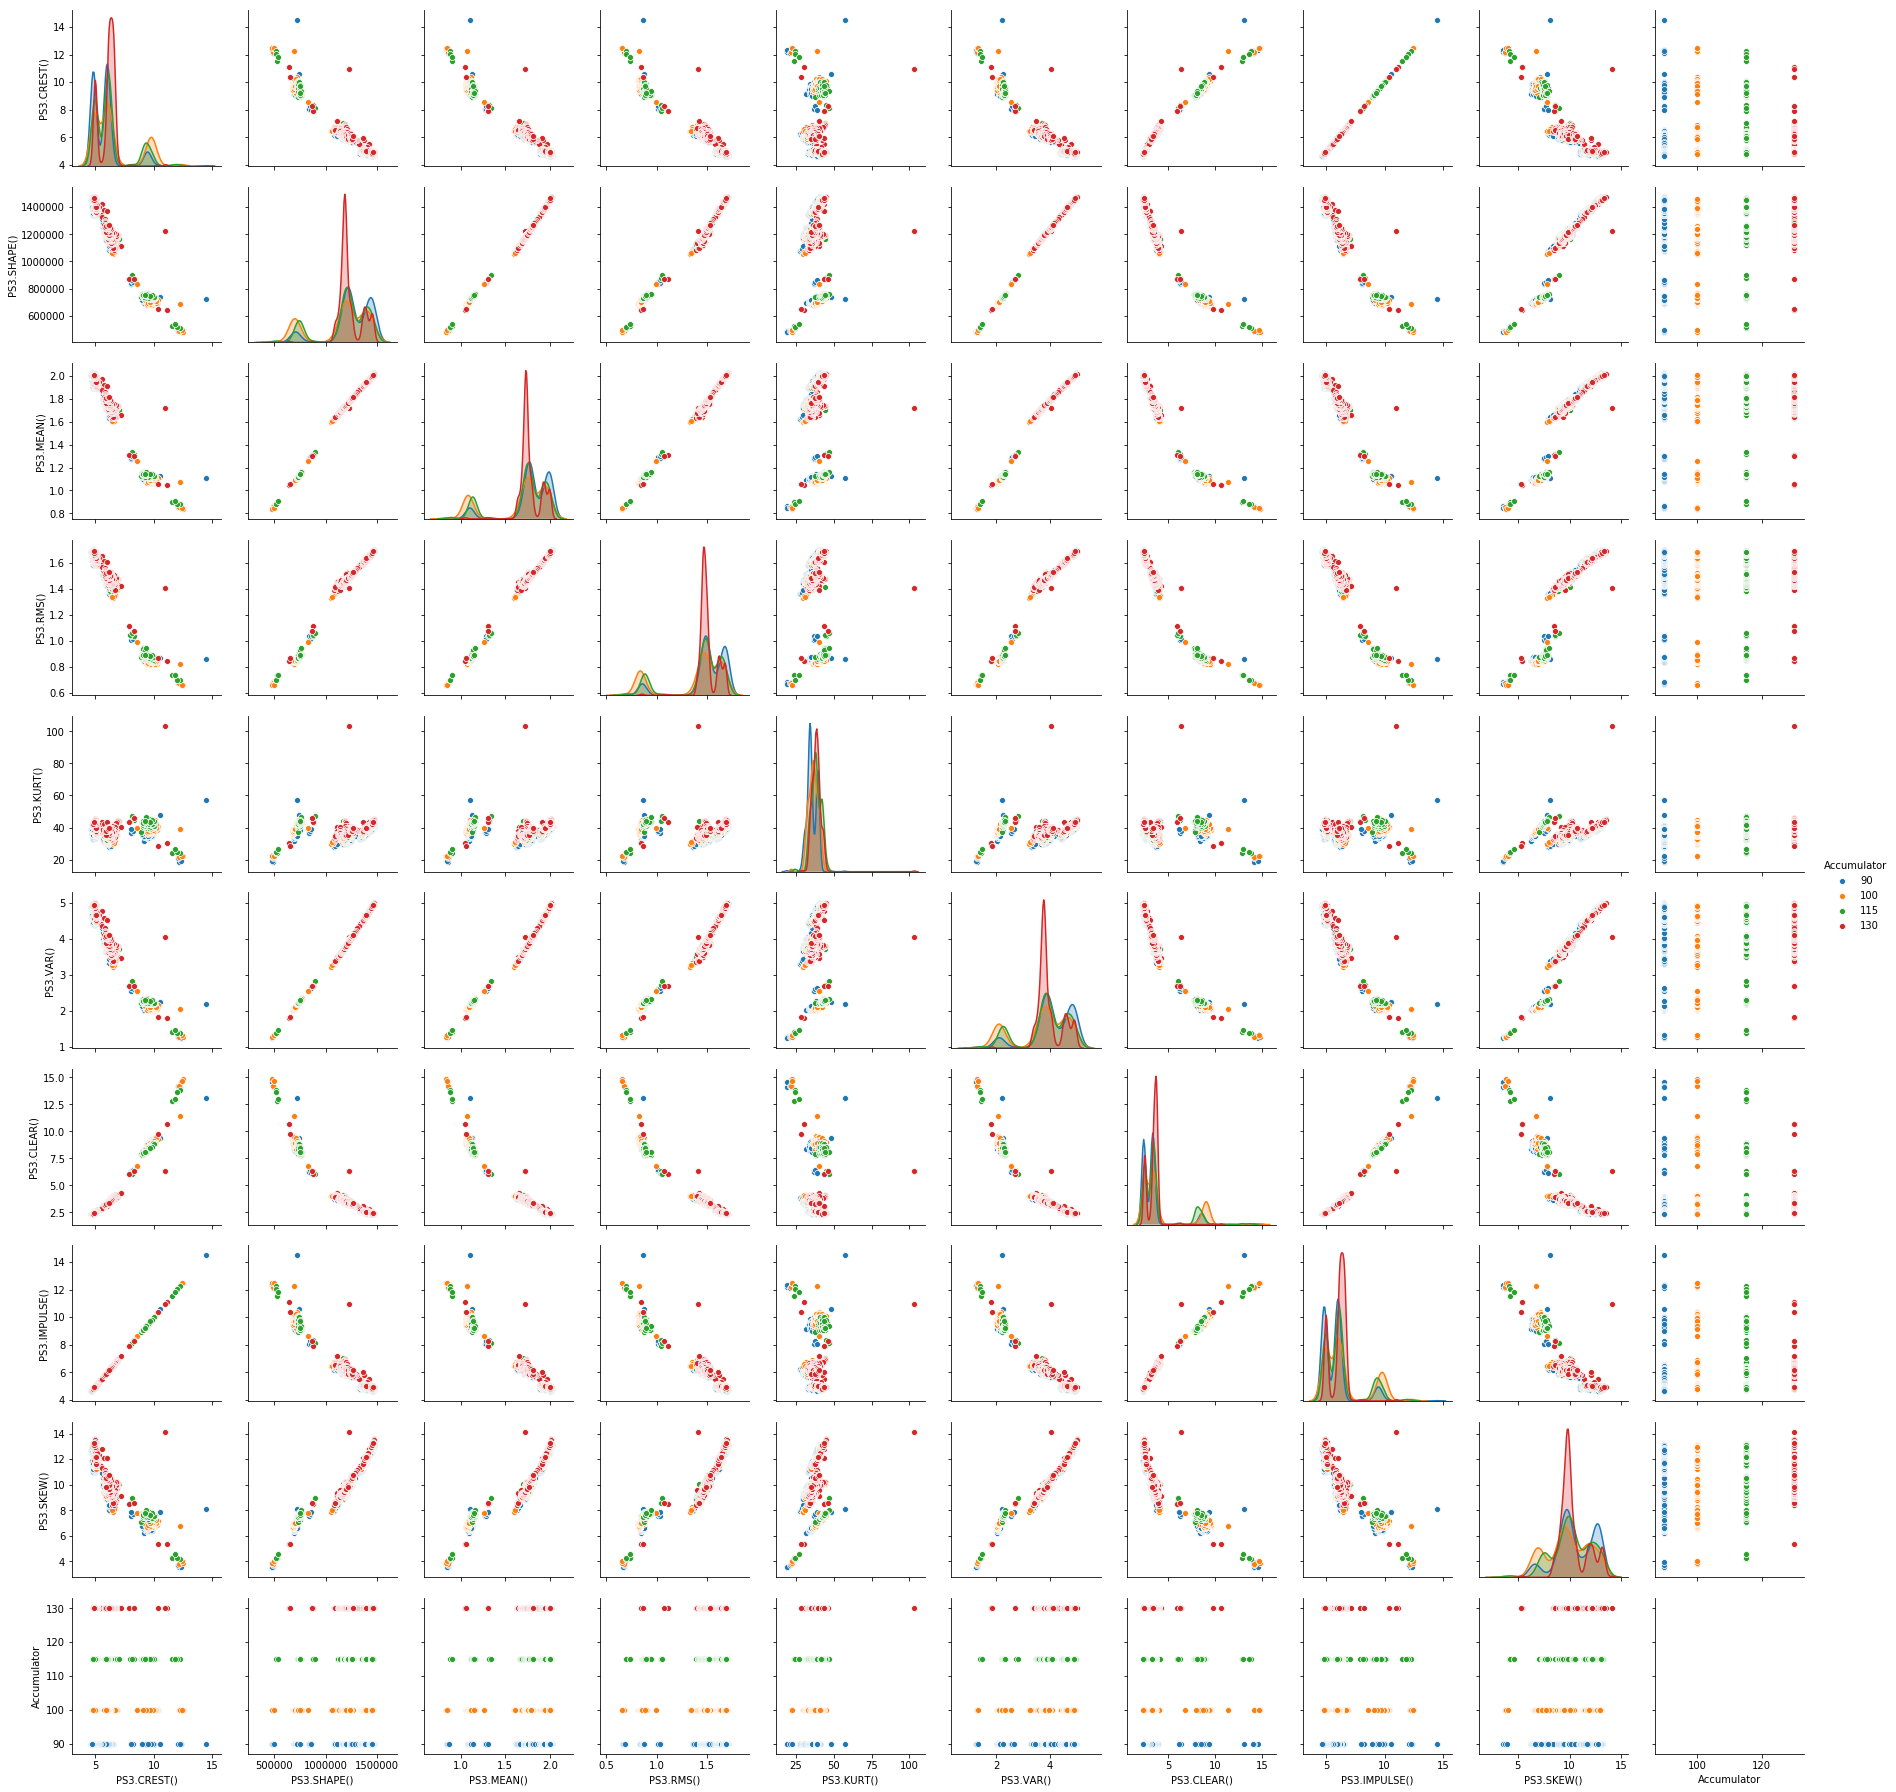

In [70]:
sensor='PS3'
cond = 3
sns.pairplot(pd.concat([df_dict[sens_dict_inv[sensor]],profile.iloc[:,cond]],axis=1),hue=target_conditions_str[cond])

Now it's time to combine all the extracted features and see it's correlation with profile.

In [27]:
all_features_all = pd.concat([features_CP_all,features_CE_all,features_SE_all,features_PS1_all,features_PS2_all,
                              features_PS3_all,features_PS4_all,features_PS5_all,features_PS6_all,features_EPS1_all,
                              features_TS1_all,features_TS2_all,features_TS3_all,features_TS4_all,features_FS1_all,
                              features_FS2_all,features_VS1_all],axis=1)

In [28]:
all_features = pd.concat([all_features_all, PCA_all, all_features_fourier,deriv_all],axis=1)

### Normaliza los Features

In [ ]:
scaler = StandardScaler()
data_n=scaler.fit_transform(all_features)

# 3. Feature Selection

We have 9x17 features generated. Most of them are highly correlated, as concluded in last section. The goal now is to choose the best ones in order to predict the 5 conditions. We'll make use of the gradient boosting classificator for estimating feature importance, since it is a very robust model that is usually robust towards overfitting, and random forest for quick test.

Let's define a shuffling function.

In [131]:
def X_y_shuffle(X,y):
    n=1
    try:
        n=y.shape[1]
    except:
        pass
    Xy = pd.concat([X, y],axis=1).sample(frac=1)
    X_shuffled = Xy.iloc[:,:-n]
    y_shuffled = Xy.iloc[:,-n:]
    return X_shuffled, y_shuffled

In [ ]:
def Xy_shuffle1(X,y,random_state=7):
    Xy = pd.concat([X, y],axis=1).sample(frac=1,random_state = random_state)
    X_shuffled = Xy.iloc[:,:-1]
    y_shuffled = Xy.iloc[:,-1]
    return X_shuffled, y_shuffled

In [130]:
y0.iloc[:,1].shape[1]

IndexError: tuple index out of range

### Note: To avoid autoscrolling

In [29]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [30]:
def k_best_features(df,clf,num=10):
    feature_list=df.columns[pd.DataFrame(clf.feature_importances_).abs().sort_values(by=0,ascending=False)[:num].index]
    sf_by_fi = df.loc[:,feature_list]
    print(feature_list)
    return sf_by_fi

In [ ]:
def k_best_features1(df,clf,num=10):
    feature_list=df.columns[pd.DataFrame(clf.coef_).abs().sort_values(by=0,ascending=False)[:num].index]
    sf_by_fi = df.loc[:,feature_list]
    print(feature_list)
    return sf_by_fi

In [150]:
X0 = all_features
y0 = profile
X_train, X_test, y_train, y_test = train_test_split(X0,y0,test_size=0.25,shuffle=True)

In [84]:
importances = pd.DataFrame()
importances['Feature']=all_features.columns
for i in range(100):
    clf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1)
    clf.fit(all_features.fillna(0), profile)
    importances['n_{}'.format(i)]=clf.feature_importances_
    if (i+1)%10 == 0:
        print('{} de 100'.format(i+1))
feature_importances=pd.DataFrame()
feature_importances['mean']=importances.mean(axis=1)
feature_importances['std']=importances.std(axis=1)
feature_importances.index=all_features.columns

10 de 100
20 de 100
30 de 100
40 de 100
50 de 100
60 de 100
70 de 100
80 de 100
90 de 100
100 de 100


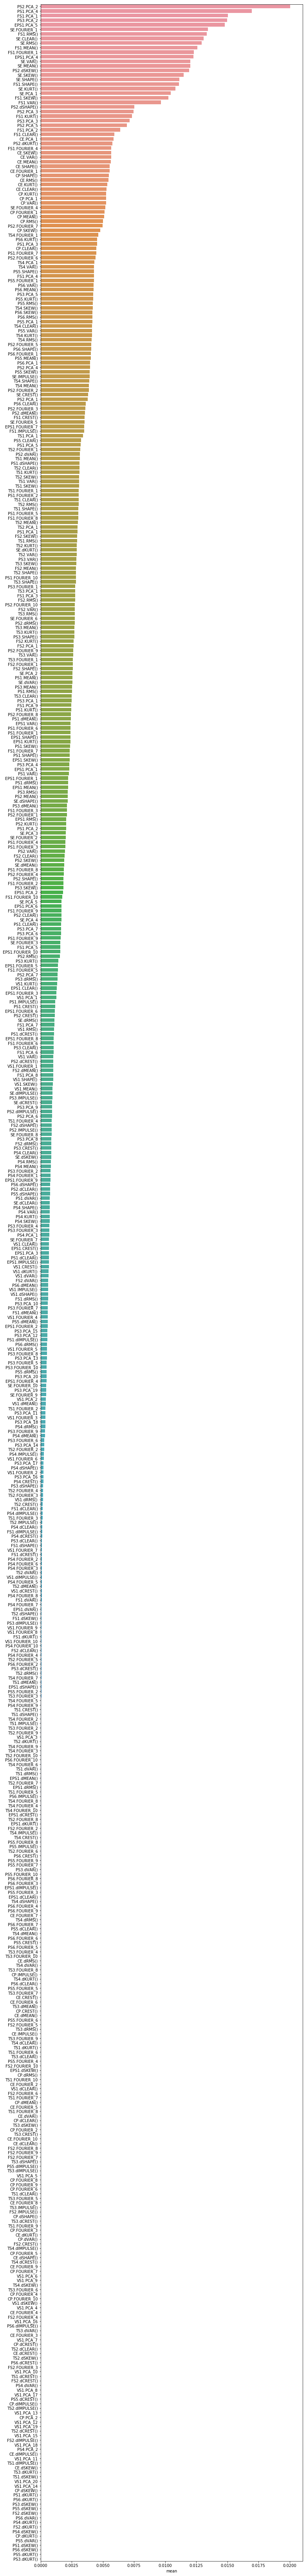

In [86]:
plt.figure(figsize=(12,120))
sns.barplot(x=feature_importances['mean'],y=feature_importances.index,
            order=feature_importances.sort_values(by='mean',ascending=False).index,
            #**{'xerr':feature_importances['std']}
           )

## 4.0 Single model

In [151]:
X0,y0 = X_y_shuffle(X0,y0)

In [155]:
xtr = pd.DataFrame()
dpth={0:1,1:3,2:8,3:10,4:10}
for j in range(40):
    features_scores=[]
    for col in X0.columns:
        xtmp = pd.concat([xtr, X0.loc[:,col]],axis=1)
        cv_scores = []
        #print('trying {}...'.format(col))
        for cond in range(5):
            clf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1,random_state=7,
                                         max_depth=dpth[cond])
            cv_scores.append(cross_val_score(clf,xtmp,y0.iloc[:,cond],scoring='f1_weighted',cv=5,n_jobs=-1))
        features_scores.append(np.mean(cv_scores))
        #print('trying {}...Mean score is {}.'.format(col,np.mean(cv_scores)))
    xtr=pd.concat([xtr,X0.iloc[:,np.argmax(features_scores)]],axis=1)
    print('Feature No. {}: {}. F1 score is {}.'.format(j+1,X0.columns[np.argmax(features_scores)],
                                                       np.max(features_scores)))

Feature No. 1: PS6.RMS(). F1 score is 0.6941785271665418.
Feature No. 2: PS3.PCA_2. F1 score is 0.8517184860935515.
Feature No. 3: FS1.VAR(). F1 score is 0.9407559696618365.
Feature No. 4: CP.PCA_1. F1 score is 0.9668426566842848.
Feature No. 5: PS1.dSHAPE(). F1 score is 0.9750251420482831.
Feature No. 6: PS2.PCA_3. F1 score is 0.9817235433646977.
Feature No. 7: PS1.RMS(). F1 score is 0.9849855543299513.
Feature No. 8: PS6.dSHAPE(). F1 score is 0.9866111179237254.
Feature No. 9: SE.PCA_1. F1 score is 0.9878859189144794.
Feature No. 10: TS2.SHAPE(). F1 score is 0.9889749596162938.
Feature No. 11: PS2.dMEAN(). F1 score is 0.9897056424540825.
Feature No. 12: FS1.FOURIER_2. F1 score is 0.9900708402971925.
Feature No. 13: CP.KURT(). F1 score is 0.9910694668989046.
Feature No. 14: FS2.SHAPE(). F1 score is 0.9906086827434195.
Feature No. 15: FS1.FOURIER_2. F1 score is 0.9910668013840959.
Feature No. 16: PS1.FOURIER_8. F1 score is 0.9916138491965819.
Feature No. 17: PS2.PCA_5. F1 score is 0.99

In [452]:
X_sel0 = X0.loc[:,list(set(['PS6.RMS()', 'PS3.PCA_2', 'FS1.VAR()', 'CP.PCA_1', 'PS1.dSHAPE()',
                   'PS2.PCA_3', 'PS1.RMS()', 'PS6.dSHAPE()', 'SE.PCA_1', 'TS2.SHAPE()',
                   'PS2.dMEAN()', 'FS1.FOURIER_2', 'CP.KURT()', 'FS2.SHAPE()',
                   'FS1.FOURIER_2', 'PS1.FOURIER_8', 'PS2.PCA_5', 'FS1.PCA_5',
                   'PS3.MEAN()', 'PS5.SHAPE()', 'CP.KURT()', 'PS2.dVAR()',
                   'VS1.dVAR()', 'TS2.CLEAR()', 'PS1.MEAN()', 'PS2.dSKEW()', 'SE.PCA_1',
                   'SE.RMS()', 'FS2.dKURT()', 'PS3.PCA_12', 'PS1.dCREST()', 'SE.KURT()',
                   'PS2.dRMS()', 'CE.KURT()', 'PS1.dSKEW()',
                   'SE.dCREST()', 'PS2.dMEAN()', 'PS2.SKEW()']))]

In [453]:
clf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1,random_state=7)
cross_val_score(clf,X_sel0,y0.iloc[:,4],cv=5,scoring='f1_weighted').mean()

0.9794517369078571

Text(0.5, 1.0, 'Stable Flag Classification Score')

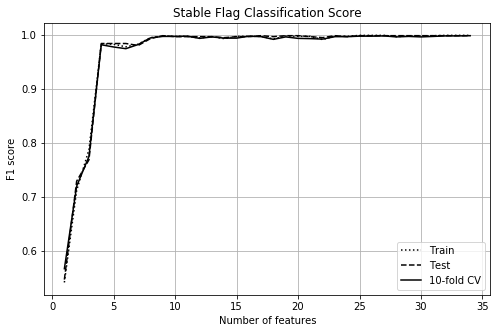

In [454]:
num = 0
X_train, X_test, y_train, y_test = train_test_split(X_sel0,y0.iloc[:,num].ravel(),test_size=0.25,shuffle=True)

f1_train = []
f1_test = []
f1_cv = []
n=X_sel0.shape[1]
for i in range(n):
    clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1,random_state=7,max_depth=3)
    clf_rf.fit(X_train.iloc[:,:i+1],y_train)
    pred_train = clf_rf.predict(X_train.iloc[:,:i+1])
    pred_rf = clf_rf.predict(X_test.iloc[:,:i+1])
    f1_train.append(f1_score(y_train.ravel(),pred_train,average='weighted'))
    f1_test.append(f1_score(y_test,pred_rf,average='weighted'))
    X_5, y_5 = X_y_shuffle(X_sel0.iloc[:,:i+1],y0.iloc[:,num])
    scores = cross_val_score(clf_rf, X_5, y_5, cv=10)
    f1_cv.append(scores.mean())
    
plt.figure(figsize=(8,5))
plt.plot(np.arange(n)+1,f1_train,linestyle=':',color='k')
plt.plot(np.arange(n)+1,f1_test,linestyle='--',color='k')
plt.plot(np.arange(n)+1,f1_cv,linestyle='-',color='k')
plt.xlabel('Number of features')
plt.ylabel('F1 score')
plt.legend(['Train','Test','10-fold CV'])
plt.grid(True)
plt.title('Stable Flag Classification Score')

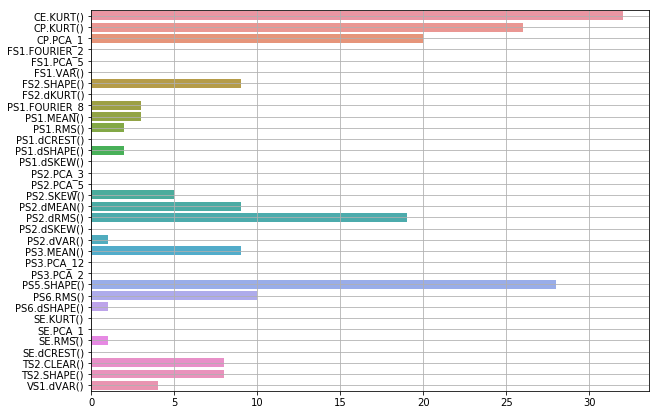

In [455]:
imp1 = pd.DataFrame()
imp1['feature']=X_train.columns
imp1['importance']=np.round(200*clf_rf.feature_importances_)
imp1['cond']=1
plt.figure(figsize=(10,7))
sns.barplot(y=X_train.columns,x=np.round(200*clf_rf.feature_importances_),order=X_train.columns.sort_values())
plt.grid(True)

Text(0.5, 1.0, 'Stable Flag Classification Score')

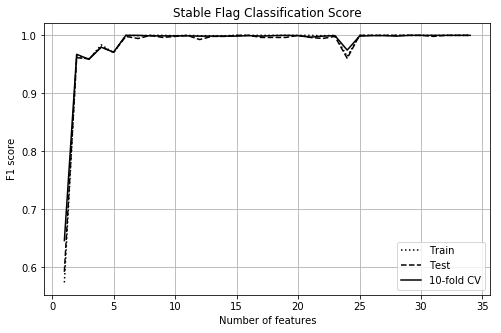

In [456]:
num = 1
X_train, X_test, y_train, y_test = train_test_split(X_sel0,y0.iloc[:,num].ravel(),test_size=0.25,shuffle=True)

f1_train = []
f1_test = []
f1_cv = []
n=X_sel0.shape[1]
for i in range(n):
    clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1,random_state=7,max_depth=3)
    clf_rf.fit(X_train.iloc[:,:i+1],y_train)
    pred_train = clf_rf.predict(X_train.iloc[:,:i+1])
    pred_rf = clf_rf.predict(X_test.iloc[:,:i+1])
    f1_train.append(f1_score(y_train.ravel(),pred_train,average='weighted'))
    f1_test.append(f1_score(y_test,pred_rf,average='weighted'))
    X_5, y_5 = X_y_shuffle(X_sel0.iloc[:,:i+1],y0.iloc[:,num])
    scores = cross_val_score(clf_rf, X_5, y_5, cv=10)
    f1_cv.append(scores.mean())
    
plt.figure(figsize=(8,5))
plt.plot(np.arange(n)+1,f1_train,linestyle=':',color='k')
plt.plot(np.arange(n)+1,f1_test,linestyle='--',color='k')
plt.plot(np.arange(n)+1,f1_cv,linestyle='-',color='k')
plt.xlabel('Number of features')
plt.ylabel('F1 score')
plt.legend(['Train','Test','10-fold CV'])
plt.grid(True)
plt.title('Stable Flag Classification Score')

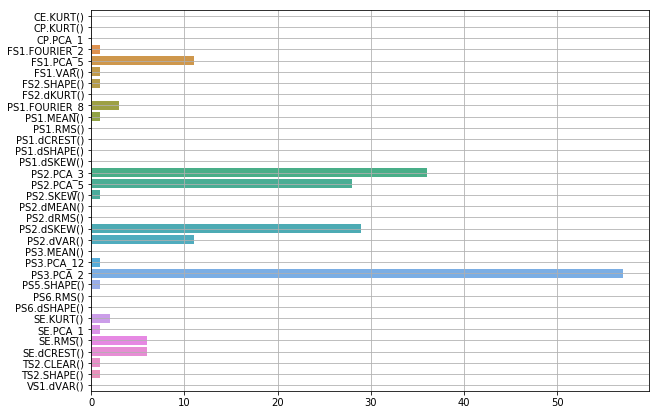

In [457]:
imp2 = pd.DataFrame()
imp2['feature']=X_train.columns
imp2['importance']=np.round(200*clf_rf.feature_importances_)
imp2['cond']=2
plt.figure(figsize=(10,7))
sns.barplot(y=X_train.columns,x=np.round(200*clf_rf.feature_importances_),order=X_train.columns.sort_values())
plt.grid(True)

Text(0.5, 1.0, 'Stable Flag Classification Score')

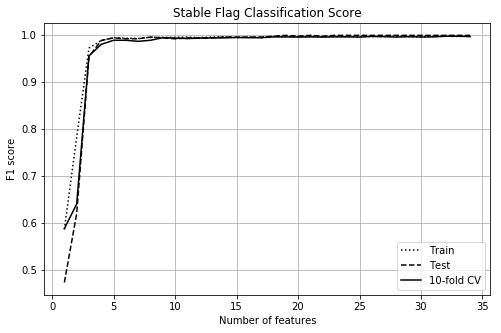

In [458]:
num = 2
X_train, X_test, y_train, y_test = train_test_split(X_sel0,y0.iloc[:,num].ravel(),test_size=0.25,shuffle=True)

f1_train = []
f1_test = []
f1_cv = []
n=X_sel0.shape[1]
for i in range(n):
    clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1,random_state=7,max_depth=10)
    clf_rf.fit(X_train.iloc[:,:i+1],y_train)
    pred_train = clf_rf.predict(X_train.iloc[:,:i+1])
    pred_rf = clf_rf.predict(X_test.iloc[:,:i+1])
    f1_train.append(f1_score(y_train.ravel(),pred_train,average='weighted'))
    f1_test.append(f1_score(y_test,pred_rf,average='weighted'))
    X_5, y_5 = X_y_shuffle(X_sel0.iloc[:,:i+1],y0.iloc[:,num])
    scores = cross_val_score(clf_rf, X_5, y_5, cv=10)
    f1_cv.append(scores.mean())
    
plt.figure(figsize=(8,5))
plt.plot(np.arange(n)+1,f1_train,linestyle=':',color='k')
plt.plot(np.arange(n)+1,f1_test,linestyle='--',color='k')
plt.plot(np.arange(n)+1,f1_cv,linestyle='-',color='k')
plt.xlabel('Number of features')
plt.ylabel('F1 score')
plt.legend(['Train','Test','10-fold CV'])
plt.grid(True)
plt.title('Stable Flag Classification Score')

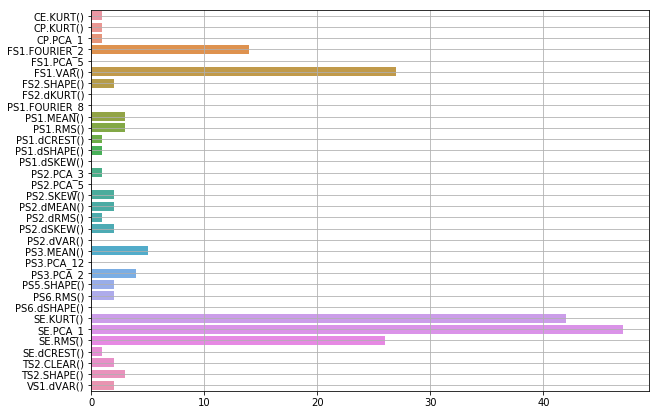

In [459]:
imp3 = pd.DataFrame()
imp3['feature']=X_train.columns
imp3['importance']=np.round(200*clf_rf.feature_importances_)
imp3['cond']=3
plt.figure(figsize=(10,7))
sns.barplot(y=X_train.columns,x=np.round(200*clf_rf.feature_importances_),order=X_train.columns.sort_values())
plt.grid(True)

Text(0.5, 1.0, 'Stable Flag Classification Score')

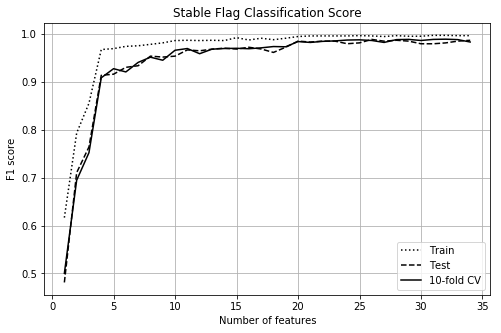

In [460]:
num = 3
X_train, X_test, y_train, y_test = train_test_split(X_sel0,y0.iloc[:,num].ravel(),test_size=0.25,shuffle=True)

f1_train = []
f1_test = []
f1_cv = []
n=X_sel0.shape[1]
for i in range(n):
    clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1,random_state=7,max_depth=10)
    clf_rf.fit(X_train.iloc[:,:i+1],y_train)
    pred_train = clf_rf.predict(X_train.iloc[:,:i+1])
    pred_rf = clf_rf.predict(X_test.iloc[:,:i+1])
    f1_train.append(f1_score(y_train.ravel(),pred_train,average='weighted'))
    f1_test.append(f1_score(y_test,pred_rf,average='weighted'))
    X_5, y_5 = X_y_shuffle(X_sel0.iloc[:,:i+1],y0.iloc[:,num])
    scores = cross_val_score(clf_rf, X_5, y_5, cv=10)
    f1_cv.append(scores.mean())
    
plt.figure(figsize=(8,5))
plt.plot(np.arange(n)+1,f1_train,linestyle=':',color='k')
plt.plot(np.arange(n)+1,f1_test,linestyle='--',color='k')
plt.plot(np.arange(n)+1,f1_cv,linestyle='-',color='k')
plt.xlabel('Number of features')
plt.ylabel('F1 score')
plt.legend(['Train','Test','10-fold CV'])
plt.grid(True)
plt.title('Stable Flag Classification Score')

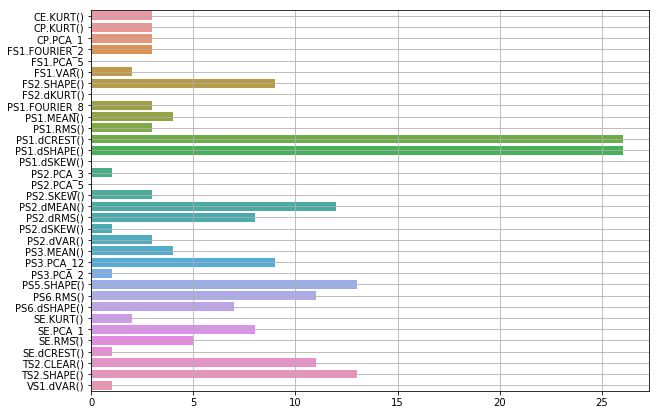

In [461]:
imp4 = pd.DataFrame()
imp4['feature']=X_train.columns
imp4['importance']=np.round(200*clf_rf.feature_importances_)
imp4['cond']=4
plt.figure(figsize=(10,7))
sns.barplot(y=X_train.columns,x=np.round(200*clf_rf.feature_importances_),order=X_train.columns.sort_values())
plt.grid(True)

Text(0.5, 1.0, 'Stable Flag Classification Score')

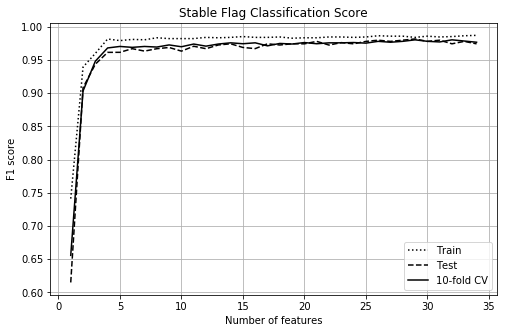

In [462]:
num = 4
X_train, X_test, y_train, y_test = train_test_split(X_sel0,
                                                    y0.iloc[:,num].ravel(),test_size=0.25,shuffle=True)

f1_train = []
f1_test = []
f1_cv = []
n=X_sel0.shape[1]
for i in range(n):
    clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1,random_state=7,max_depth=10)
    clf_rf.fit(X_train.iloc[:,:i+1],y_train)
    pred_train = clf_rf.predict(X_train.iloc[:,:i+1])
    pred_rf = clf_rf.predict(X_test.iloc[:,:i+1])
    f1_train.append(f1_score(y_train.ravel(),pred_train,average='weighted'))
    f1_test.append(f1_score(y_test,pred_rf,average='weighted'))
    X_5, y_5 = X_y_shuffle(X_sel0.iloc[:,:i+1],y0.iloc[:,num])
    scores = cross_val_score(clf_rf, X_5, y_5, cv=10)
    f1_cv.append(scores.mean())
    
plt.figure(figsize=(8,5))
plt.plot(np.arange(n)+1,f1_train,linestyle=':',color='k')
plt.plot(np.arange(n)+1,f1_test,linestyle='--',color='k')
plt.plot(np.arange(n)+1,f1_cv,linestyle='-',color='k')
plt.xlabel('Number of features')
plt.ylabel('F1 score')
plt.legend(['Train','Test','10-fold CV'])
plt.grid(True)
plt.title('Stable Flag Classification Score')

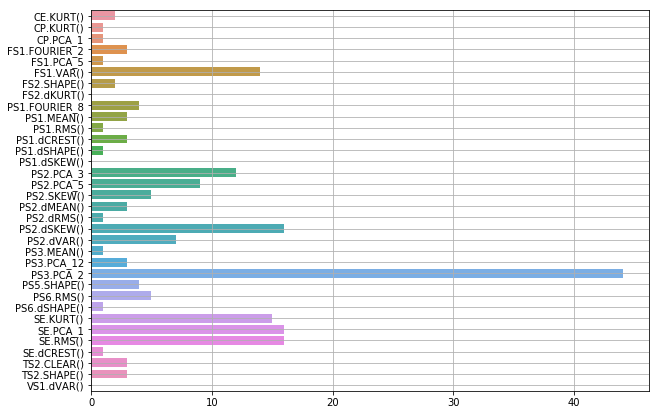

In [463]:
imp5 = pd.DataFrame()
imp5['feature']=X_train.columns
imp5['importance']=np.round(200*clf_rf.feature_importances_)
imp5['cond']=5
plt.figure(figsize=(10,7))
sns.barplot(y=X_train.columns,x=np.round(200*clf_rf.feature_importances_),order=X_train.columns.sort_values())
plt.grid(True)

In [472]:
imp=pd.concat([imp1[imp1['importance']>0],
               imp2[imp2['importance']>0],
               imp3[imp3['importance']>0],
               imp4[imp4['importance']>0],
               imp5[imp5['importance']>0]])

In [485]:
imp.reset_index(drop=True,inplace=True)

In [473]:
circos_data=[]
for x in range(imp['feature'].nunique()):
    circos_data.append('chr')
circos_data = pd.DataFrame({'prefix':circos_data})
circos_data['prefix2'] = '-'
circos_data['idx']=imp.groupby('feature').sum().index.values
circos_data['label']=imp.groupby('feature').sum().index.values
circos_data['start']=0
circos_data['end']=imp.groupby('feature').sum()['importance'].values.astype(int)*2
#circos_data['color']=['chr'+str(elem+1) for elem in circos_data.index.values]
circos_data['color']='blue'

In [474]:
c2=[]
for x in range(5):
    c2.append('chr')
c2=pd.DataFrame({'prefix':c2})
c2['prefix2'] = '-'
c2['idx'] = ['c1','c2','c3','c4','c5']
c2['label'] = ['Cooler','Valve','Pump','Accumulator','Stable']
c2['start'] = 0
c2['end'] = imp.groupby('cond').sum().values.astype(int)
c2['color'] = 'black'
#circos_data=pd.concat([circos_data,c2])

In [475]:
circos_data=pd.concat([circos_data,c2])

In [476]:
circos_data.to_csv('/home/lsi04/Escritorio/HydraulicSys/Figures/figure_6/data.txt',sep=' ',header=None, index=None)

In [486]:
circos_links=pd.DataFrame()
circos_links['start']=imp.sort_values(by=['cond','importance'],ascending=False)['feature']
circos_links['st_begin']=imp.sort_values(by=['feature','importance'],ascending=False).groupby('feature').cumsum()['importance'].shift(1).fillna(0).astype(int)*2
circos_links['st_end']=imp.sort_values(by=['feature','importance'],ascending=False).groupby('feature').cumsum()['importance'].astype(int)*2
circos_links['end']=['c'+str(j) for j in imp.sort_values(by=['cond','importance'],ascending=False)['cond'].values]
circos_links['end_begin']=imp.sort_values(by=['cond','importance'],ascending=False).groupby('cond').cumsum().shift(1).fillna(0).astype(int)
circos_links['end_end']=imp.sort_values(by=['cond','importance'],ascending=False).groupby('cond').cumsum().astype(int)
circos_links['end_begin']=np.where((circos_links['end_end']<=circos_links['end_begin']),0,circos_links['end_begin'])
circos_links['st_begin']=np.where((circos_links['end_end']-circos_links['end_begin'])==(circos_links['st_end']-circos_links['st_begin']),
                                  circos_links['st_begin'],0)

In [487]:
circos_links.to_csv('/home/lsi04/Escritorio/HydraulicSys/Figures/figure_6/links.txt',sep=' ',header=None,index=None)

## 4.1 Cooler Condition

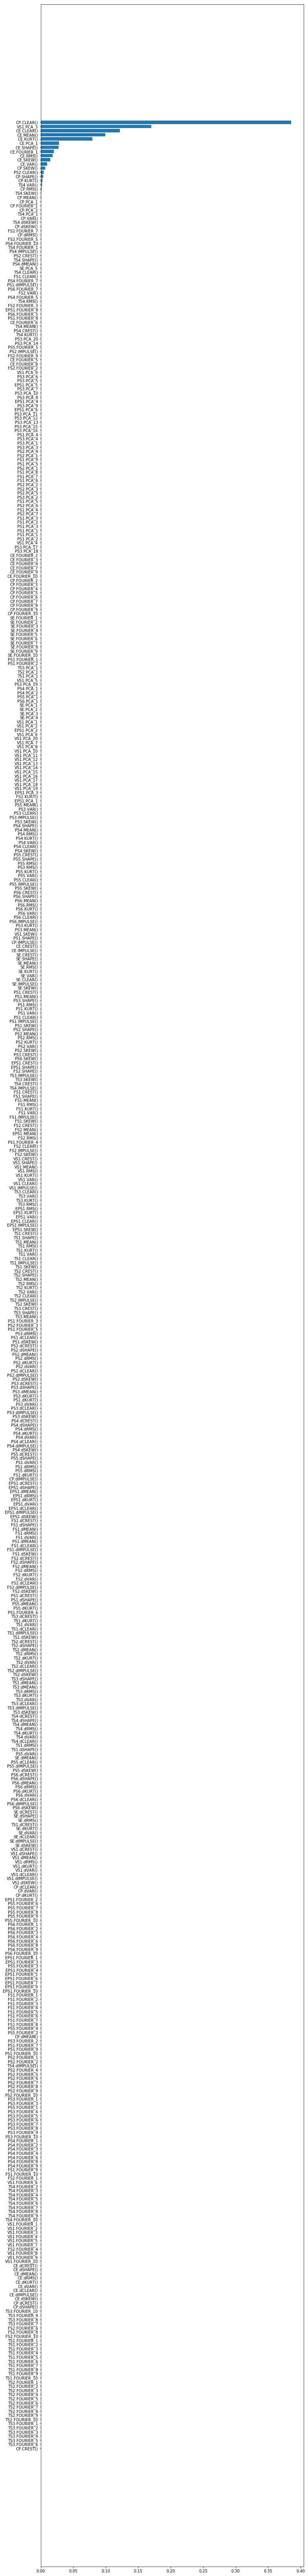

In [31]:
clf = GradientBoostingClassifier()
clf.fit(all_features.fillna(0), profile.iloc[:,0])
fig,ax=plt.subplots(figsize=(12,120))
cols = [col for col in all_features.columns]
feature_importances = pd.DataFrame([clf.feature_importances_])
feature_importances.columns=all_features.columns
feature_importances=feature_importances.sort_values(by=0,axis=1)
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(feature_importances.columns, rotation='horizontal')
plt.barh(range(len(feature_importances.columns)),np.array(feature_importances.iloc[0,:]))
plt.show()

The features derived from CE and CP are the most correlated to Cooler Condition, by far. Let's look into them.

In [32]:
selected_features_1 = k_best_features(all_features,clf,num=1)

Index(['CP.CLEAR()'], dtype='object')


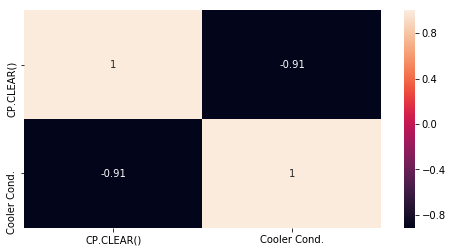

In [33]:
plt.figure(figsize=(8,4))
sns.heatmap(pd.concat([selected_features_1,profile.iloc[:,0]],axis=1).corr(), annot=True)

## 4.2 Valve Condition

Here we see all the features generated and which ones are the best to predict Valve condition

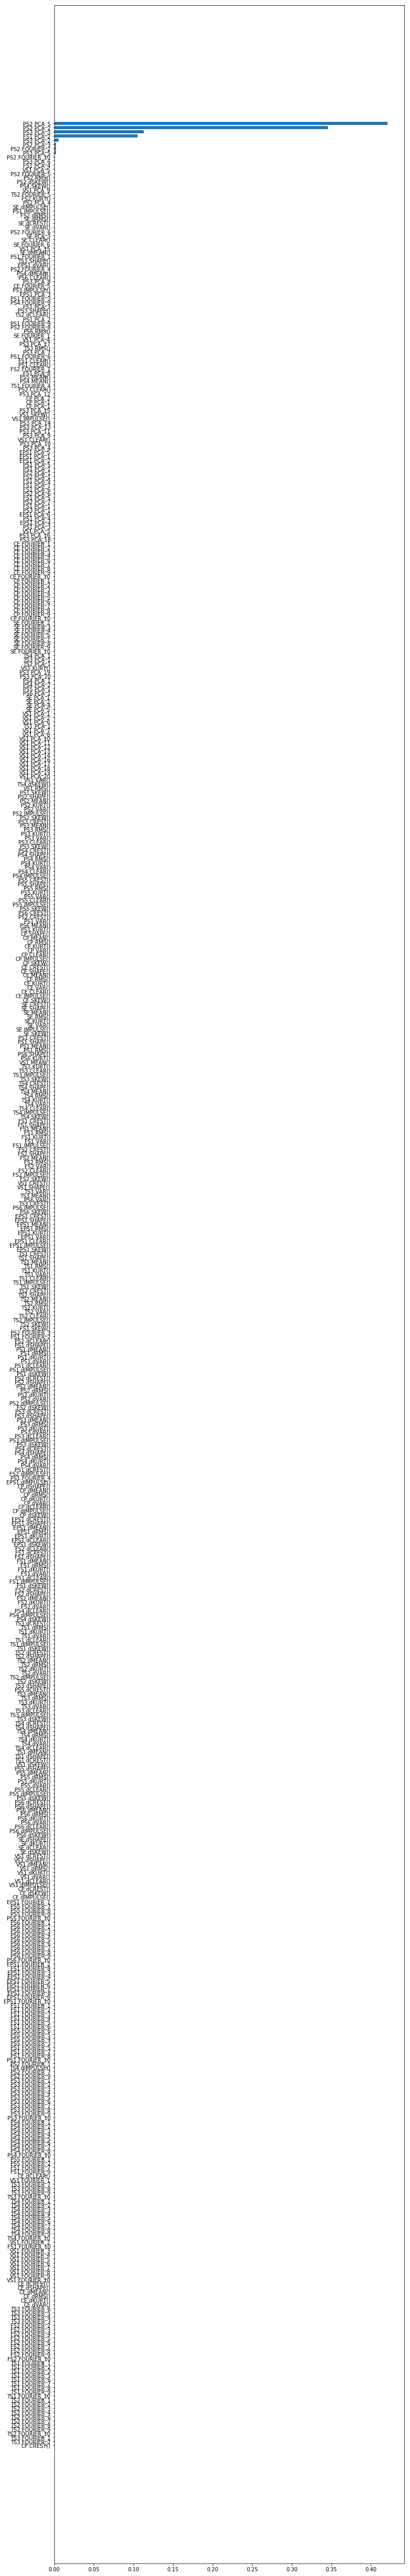

In [47]:
clf = GradientBoostingClassifier()
clf.fit(all_features, profile.iloc[:,1])
fig,ax=plt.subplots(figsize=(12,90))
cols = [col for col in all_features.columns]
feature_importances = pd.DataFrame([clf.feature_importances_])
feature_importances.columns=all_features.columns
feature_importances=feature_importances.sort_values(by=0,axis=1)
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(feature_importances.columns, rotation='horizontal')
plt.barh(range(len(feature_importances.columns)),np.array(feature_importances.iloc[0,:]))
plt.show()

Main features are PS2, PS1, SE and FS1. Let's attempt some classification.

In [48]:
selected_features_2 = k_best_features(all_features,clf,num=3)

Index(['PS2.PCA_5', 'PS2.PCA_2', 'PS3.PCA_3'], dtype='object')


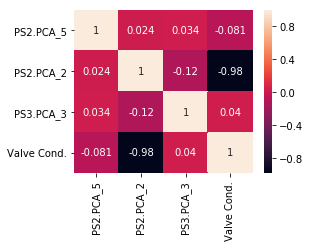

In [36]:
plt.figure(figsize=(4,3))
sns.heatmap(pd.concat([selected_features_2,profile.iloc[:,1]],axis=1).corr(), annot=True)

## 4.3 Internal Pump Leakage

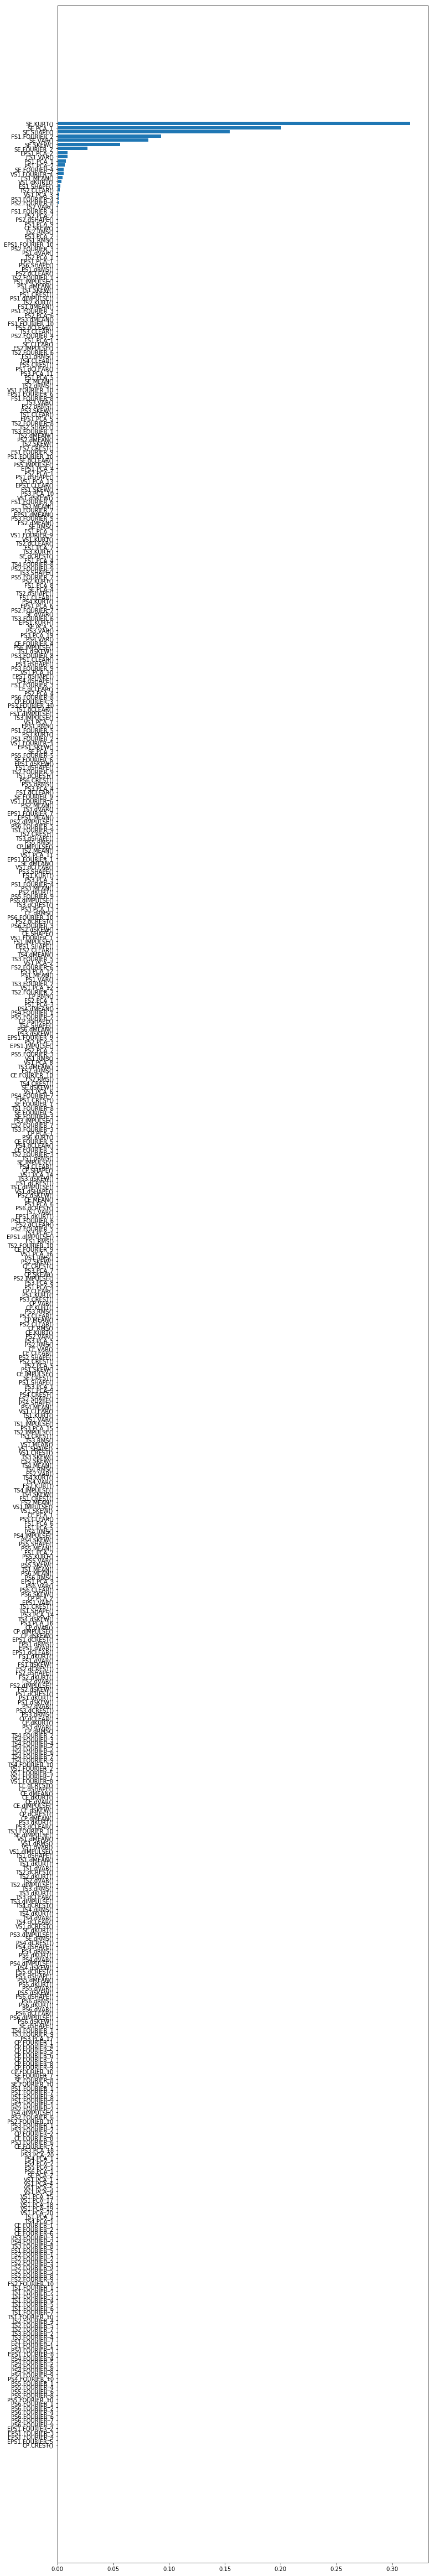

In [34]:
clf = GradientBoostingClassifier()
clf.fit(all_features, profile.iloc[:,2])
fig,ax=plt.subplots(figsize=(12,85))
cols = [col for col in all_features.columns]
feature_importances = pd.DataFrame([clf.feature_importances_])
feature_importances.columns=all_features.columns
feature_importances=feature_importances.sort_values(by=0,axis=1)
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(feature_importances.columns, rotation='horizontal')
plt.barh(range(len(feature_importances.columns)),np.array(feature_importances.iloc[0,:]))
plt.show()

In [35]:
selected_features_3 = k_best_features(all_features, clf,num=10)

Index(['SE.KURT()', 'SE.PCA_1', 'SE.SHAPE()', 'FS1.FOURIER_2', 'SE.VAR()',
       'SE.SKEW()', 'SE.FOURIER_2', 'EPS1.PCA_2', 'FS1.VAR()', 'PS1.PCA_1'],
      dtype='object')


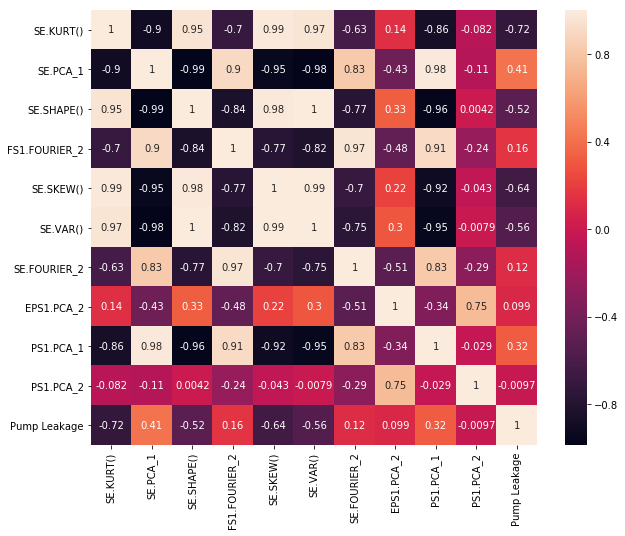

In [39]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.concat([selected_features_3,profile.iloc[:,2]],axis=1).corr(), annot=True)

## 4.4 Hydraulic Accumulator

On the reference paper, this was the most difficult condition to predict, so let's look at what can we do here.

### Gradient Boosting

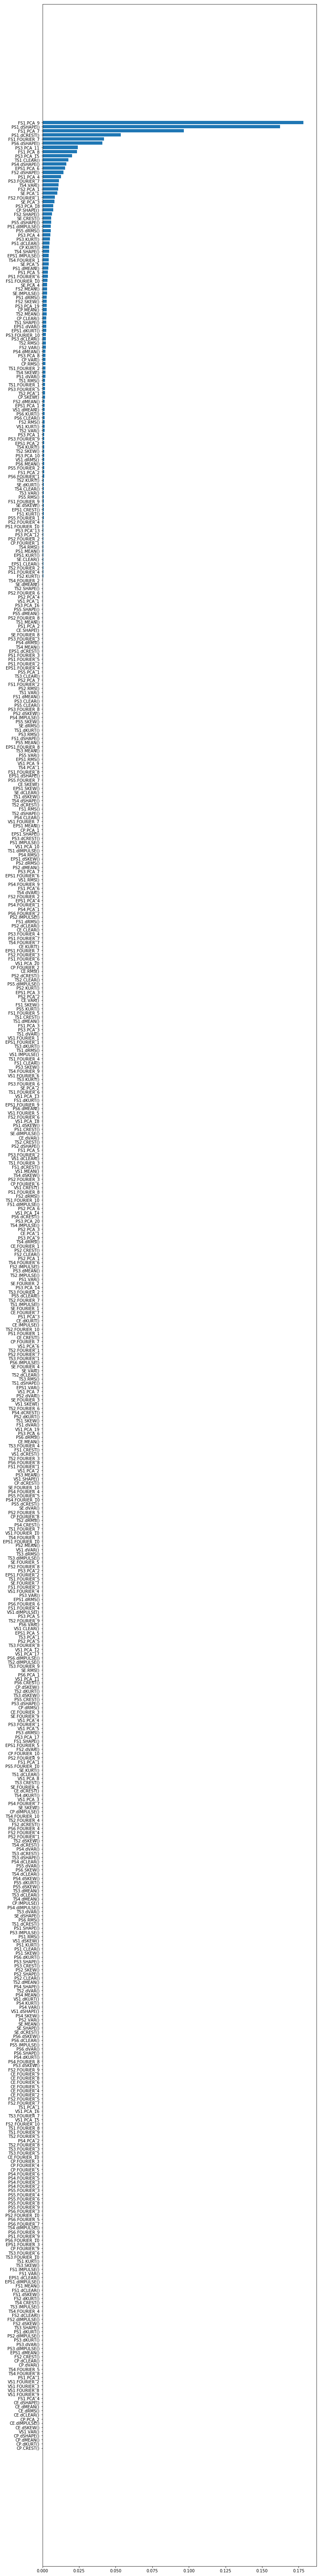

In [36]:
clf = GradientBoostingClassifier()
clf.fit(all_features, profile.iloc[:,3])
fig,ax=plt.subplots(figsize=(12,115))
cols = [col for col in all_features.columns]
feature_importances = pd.DataFrame([clf.feature_importances_])
feature_importances.columns=all_features.columns
feature_importances=feature_importances.sort_values(by=0,axis=1)
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(feature_importances.columns, rotation='horizontal')
plt.barh(range(len(feature_importances.columns)),np.array(feature_importances.iloc[0,:]))
plt.show()

In [37]:
selected_features_4 = k_best_features(all_features,clf,num=20)

Index(['FS1.PCA_9', 'PS1.dSHAPE()', 'FS1.PCA_7', 'PS1.dCREST()',
       'FS1.FOURIER_7', 'PS6.dSHAPE()', 'PS3.PCA_11', 'FS1.PCA_8',
       'PS3.PCA_15', 'TS1.CLEAR()', 'PS4.dSHAPE()', 'EPS1.PCA_6',
       'FS2.dSHAPE()', 'PS1.PCA_4', 'PS3.FOURIER_7', 'TS4.VAR()', 'FS2.PCA_1',
       'SE.PCA_1', 'FS2.FOURIER_1', 'SE.PCA_3'],
      dtype='object')


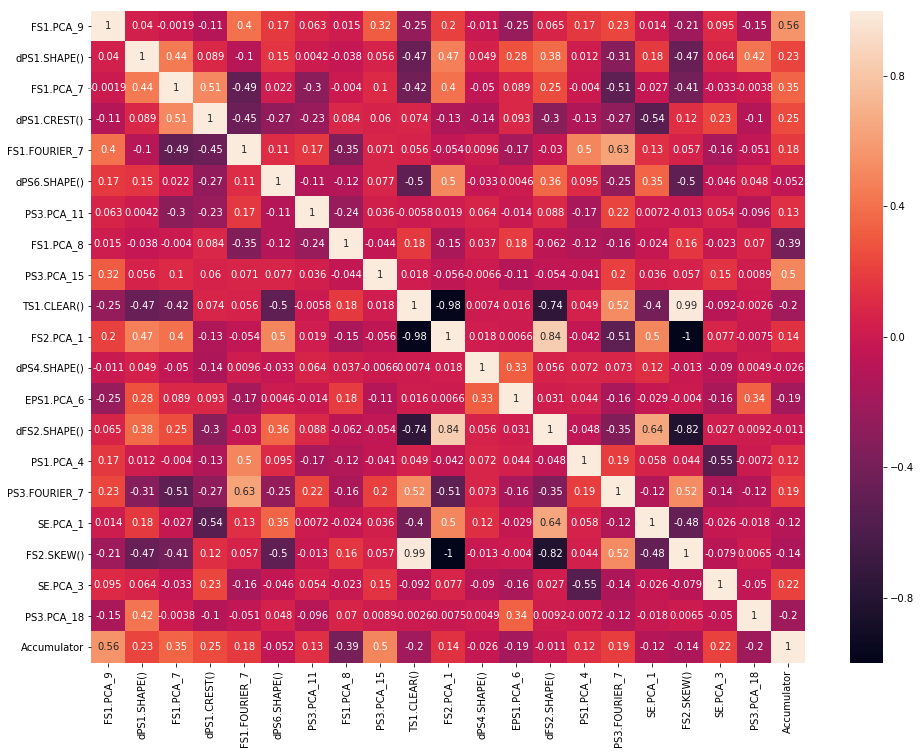

In [42]:
plt.figure(figsize=(16,12))
sns.heatmap(pd.concat([selected_features_4,profile.iloc[:,3]],axis=1).corr(), annot=True)

### Ridge Regression

In [ ]:
sel = Ridge(alpha=0.1, normalize=True, random_state=7)
sel.fit(data_n,profile.iloc[:,3])
importance=pd.DataFrame()
importance['features']=data.columns
importance['ridge_coef']=abs(sel.coef_)/sum(abs(sel.coef_))
#importance.sort_values(by='ridge_coef',ascending=False).head(10)

In [ ]:
ridge_selected_features_4=k_best_features1(data,sel,num=20)

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(pd.concat([ridge_selected_features_4,profile.iloc[:,3]],axis=1).corr(), annot=True)

### Lazo Regression

In [ ]:
sel = Lasso(alpha=0.1, normalize=True, random_state=7)
sel.fit(data_n,profile.iloc[:,3])
importance=pd.DataFrame()
importance['features']=data.columns
importance['ridge_coef']=abs(sel.coef_)/sum(abs(sel.coef_))

In [ ]:
lazo_selected_features_4=k_best_features1(data,sel,num=20)

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(pd.concat([lazo_selected_features_4,profile.iloc[:,3]],axis=1).corr(), annot=True)

### Greedy Forward Selection

In [ ]:
test_features=pd.DataFrame()
#X5,y5=Xy_shuffle(selected_features_5,profile.iloc[:,4])
clf_rf = RandomForestClassifier(min_samples_leaf=5,n_estimators=50,n_jobs=-1,random_state=24)
maxMean = 0
for col in list(np.random.RandomState(seed=42).permutation(all_features.columns)):
    test_features=test_features.join(all_features[col],how='outer')
    X4,y4=Xy_shuffle(test_features,profile.iloc[:,3])
    scores = cross_val_score(clf_rf, X4, y4, cv=6)
    if scores.mean() <= maxMean+0.0002:
        test_features.drop(columns=col,inplace=True)
    else:
        maxMean=scores.mean()
        print('{} included. Mean CV score increased to {}'.format(col,maxMean))

In [ ]:
gf_selected_features_4 = test_features

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(pd.concat([gf_selected_features_4,profile.iloc[:,3]],axis=1).corr(), annot=True)

### Backward Elimination

In [ ]:
test_ftrs = all_features.copy()
clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1,random_state=24)
maxMean=0
for col in list(np.random.RandomState(seed=42).permutation(all_features.columns)):
    test_ftrs.drop(col,axis=1,inplace=True)
    X4,y4=Xy_shuffle(test_ftrs,profile.iloc[:,3])
    scores = cross_val_score(clf_rf, X4, y4, cv=6)
    if scores.mean()>=maxMean-0.0005:
        maxMean=scores.mean()
        print('{} dropped. Mean CV score increased to {}'.format(col,maxMean))
    else:
        test_ftrs=test_ftrs.join(all_features[col])

In [ ]:
be_selected_features_4 = test_ftrs

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(pd.concat([be_selected_features_4,profile.iloc[:,3]],axis=1).corr(), annot=True)

## 4.5 Stable Flag

### Gradient Boosting

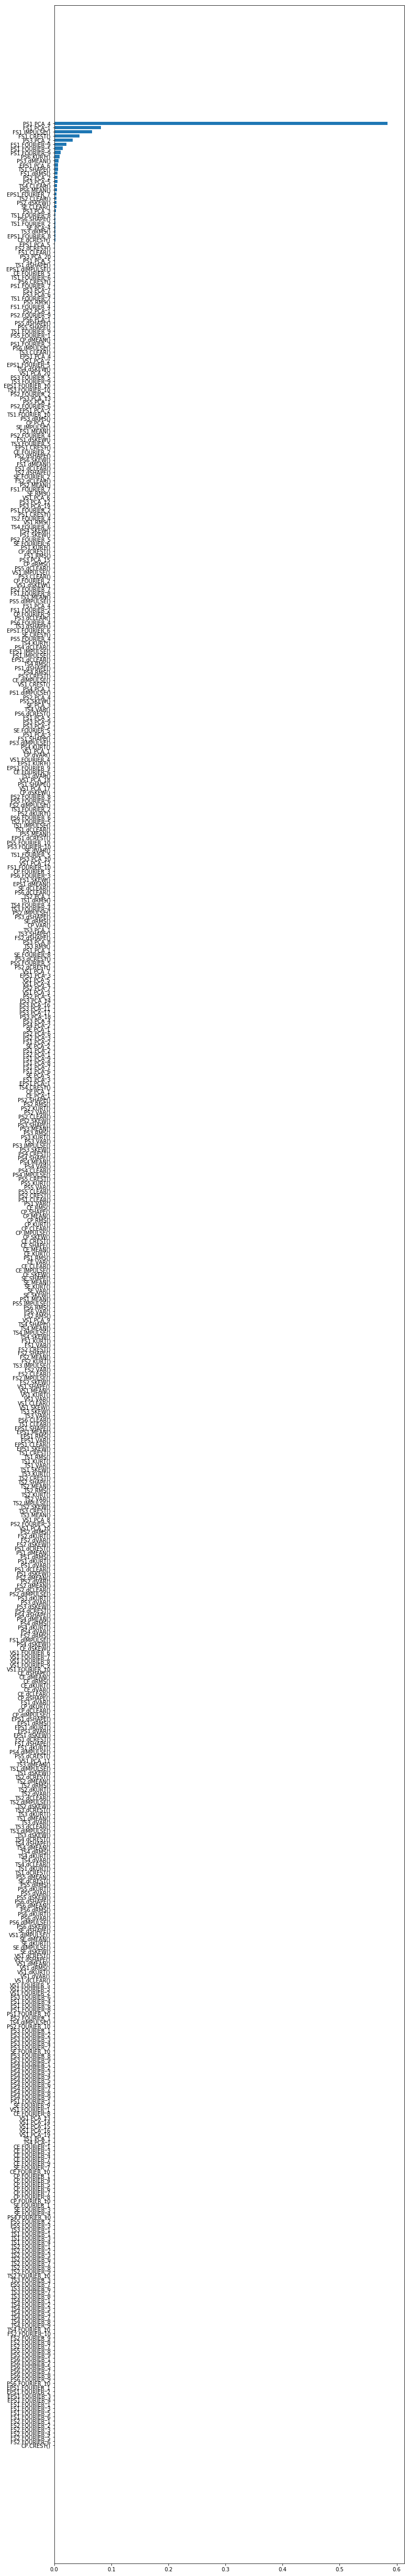

In [38]:
clf = GradientBoostingClassifier()
clf.fit(all_features, profile.iloc[:,4])
fig,ax=plt.subplots(figsize=(12,90))
cols = [col for col in all_features.columns]
feature_importances = pd.DataFrame([clf.feature_importances_])
feature_importances.columns=all_features.columns
feature_importances=feature_importances.sort_values(by=0,axis=1)
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(feature_importances.columns, rotation='horizontal')
plt.barh(range(len(feature_importances.columns)),np.array(feature_importances.iloc[0,:]))
plt.show()

In [39]:
selected_features_5 = k_best_features(all_features,clf,num=16)

Index(['PS1.PCA_4', 'FS1.PCA_1', 'FS1.IMPULSE()', 'FS1.CREST()', 'PS3.PCA_2',
       'FS1.FOURIER_9', 'PS1.FOURIER_5', 'PS1.FOURIER_9', 'PS6.KURT()',
       'PS3.dMEAN()', 'EPS1.PCA_6', 'TS1.SHAPE()', 'FS1.dRMS()', 'PS2.PCA_2',
       'PS3.PCA_5', 'TS4.CLEAR()'],
      dtype='object')


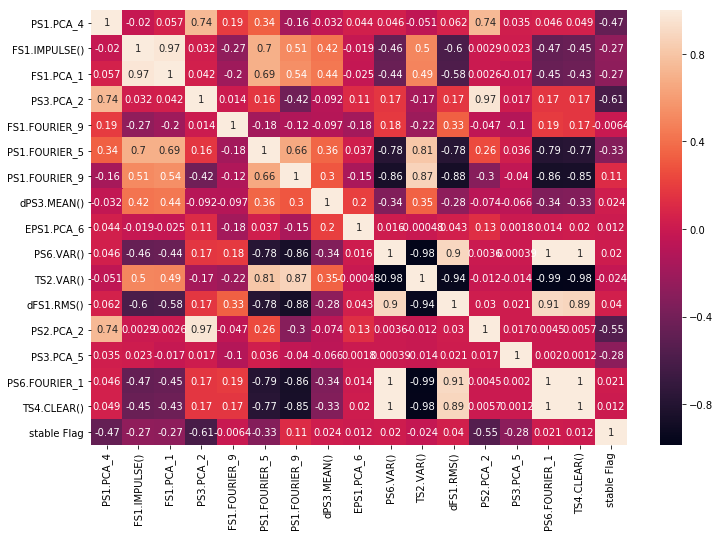

In [45]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.concat([selected_features_5,profile.iloc[:,4]],axis=1).corr(), annot=True)

### Ridge Regression

In [ ]:
sel = Ridge(alpha=0.1, normalize=True, random_state=7)
sel.fit(data_n,profile.iloc[:,4])
importance=pd.DataFrame()
importance['features']=data.columns
importance['ridge_coef']=abs(sel.coef_)/sum(abs(sel.coef_))
#importance.sort_values(by='ridge_coef',ascending=False).head(10)

In [ ]:
ridge_selected_features_5=k_best_features(data,sel,num=20)

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.concat([ridge_selected_features_5,profile.iloc[:,4]],axis=1).corr(), annot=True)

### Lasso Regression

In [ ]:
sel = Lasso(alpha=0.1, normalize=True, random_state=7)
sel.fit(data_n,profile.iloc[:,4])
importance=pd.DataFrame()
importance['features']=data.columns
importance['ridge_coef']=abs(sel.coef_)/sum(abs(sel.coef_))

In [ ]:
lasso_selected_features_5=k_best_features(data,sel,num=20)

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.concat([lasso_selected_features_5,profile.iloc[:,4]],axis=1).corr(), annot=True)

### Greedy Forward Selection

In [ ]:
test_features=pd.DataFrame()
#X5,y5=Xy_shuffle(selected_features_5,profile.iloc[:,4])
clf_rf = RandomForestClassifier(min_samples_leaf=5,n_estimators=50,n_jobs=-1)
maxMean = 0
for col in list(np.random.RandomState(seed=42).permutation(all_features.columns)):
    test_features=test_features.join(all_Feautures[col],how='outer')
    X5,y5=Xy_shuffle(test_features,profile.iloc[:,4])
    scores = cross_val_score(clf_rf, X5, y5, cv=6)
    if scores.mean() <= maxMean+0.0002:
        test_features.drop(columns=col,inplace=True)
    else:
        maxMean=scores.mean()
        print('{} included. Mean CV score increased to {}'.format(col,maxMean))

In [ ]:
gf_selected_features_5 = test_features

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.concat([gf_selected_features_5,profile.iloc[:,4]],axis=1).corr(), annot=True)

### Backward Elimination

In [ ]:
test_ftrs = all_features.copy()
clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1,random_state=24)
maxMean=0
for col in list(np.random.RandomState(seed=42).permutation(all_features.columns)):
    test_ftrs.drop(col,axis=1,inplace=True)
    X5,y5=Xy_shuffle(test_ftrs,profile.iloc[:,4])
    scores = cross_val_score(clf_rf, X5, y5, cv=6)
    if scores.mean()>=maxMean-0.0005:
        maxMean=scores.mean()
        print('{} dropped. Mean CV score increased to {}'.format(col,maxMean))
    else:
        test_ftrs=test_ftrs.join(all_features[col])

In [ ]:
be_selected_features_5 = test_ftrs

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.concat([be_selected_features_5,profile.iloc[:,4]],axis=1).corr(), annot=True)

# 5. Modelling

 - 50% Train.
 - 50% Test.
 - Ten folds for cross-validation.

## 5.1 Cooler Condition

In [40]:
X1 = selected_features_1
y1 = profile.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X1,y1,test_size=0.25,shuffle=True)

__Random Forest__

Train and test

In [41]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train,y_train)
pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test,pred_rf,digits=4))

              precision    recall  f1-score   support

           3     1.0000    1.0000    1.0000       188
          20     0.9943    0.9943    0.9943       176
         100     0.9947    0.9947    0.9947       188

   micro avg     0.9964    0.9964    0.9964       552
   macro avg     0.9963    0.9963    0.9963       552
weighted avg     0.9964    0.9964    0.9964       552



<BarContainer object of 1 artists>

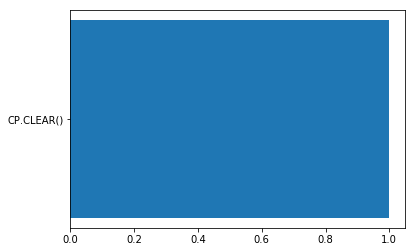

In [45]:
plt.barh(X_train.columns,clf_rf.feature_importances_)

Cross validation

In [48]:
clf_rf = RandomForestClassifier()
X_1, y_1 = X_y_shuffle(X1,y1)
scores = cross_val_score(clf_rf, X_1, y_1, cv=4)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.99 (+/- 0.00)


In [55]:
pd.concat([X1,y1],axis=1).head(2)

CP.CLEAR()  Cooler Cond.
0    0.630577             3
1    0.896977             3

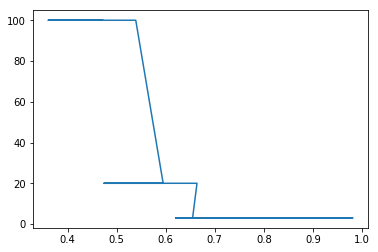

In [62]:
plt.plot(X1,y1)

__Extremely Randomized Trees__

__Gradient Boosting__

__Adaptative Boosting__

__Extreme Gradient Boosting__

__LightGBM__

## 5.2 Valve Condition

In [49]:
X2 = selected_features_2
y2 = profile.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split(X2,y2,test_size=0.5,shuffle=True)

__Multilayer Perceptron__

__Support Vector Machine__

__K-Nearest Neigbours__

__Naive Bayes__

__Decision Tree__

__Random Forest__

In [64]:
f1_train = []
f1_test = []
f1_cv = []
n=X2.shape[1]
for i in range(n):
    clf_rf = RandomForestClassifier()
    clf_rf.fit(X_train.iloc[:,:i+1],y_train)
    pred_train = clf_rf.predict(X_train.iloc[:,:i+1])
    pred_rf = clf_rf.predict(X_test.iloc[:,:i+1])
    f1_train.append(f1_score(y_train,pred_train,average='weighted'))
    f1_test.append(f1_score(y_test,pred_rf,average='weighted'))
    X_2, y_2 = X_y_shuffle(X2.iloc[:,:i+1],y2)
    scores = cross_val_score(clf_rf, X_2, y_2, cv=10)
    f1_cv.append(scores.mean())

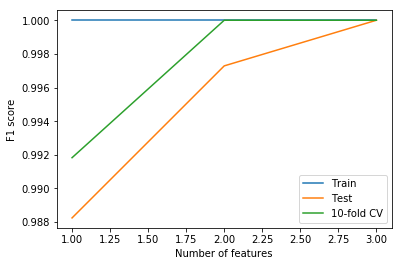

In [65]:
plt.plot(np.arange(n)+1,f1_train)
plt.plot(np.arange(n)+1,f1_test)
plt.plot(np.arange(n)+1,f1_cv)
plt.xlabel('Number of features')
plt.ylabel('F1 score')
plt.legend(['Train','Test','10-fold CV'])

In [50]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train,y_train)
pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test,pred_rf,digits=4))

              precision    recall  f1-score   support

          73     1.0000    1.0000    1.0000       193
          80     1.0000    1.0000    1.0000       189
          90     1.0000    1.0000    1.0000       163
         100     1.0000    1.0000    1.0000       558

   micro avg     1.0000    1.0000    1.0000      1103
   macro avg     1.0000    1.0000    1.0000      1103
weighted avg     1.0000    1.0000    1.0000      1103



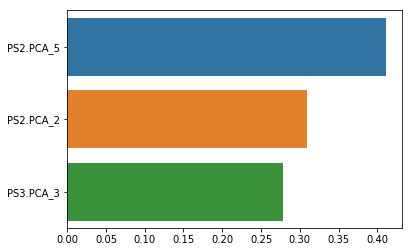

In [54]:
sns.barplot(y=X_train.columns,x=clf_rf.feature_importances_)

In [67]:
clf_rf = RandomForestClassifier()
X_2, y_2 = X_y_shuffle(X2,y2)
scores = cross_val_score(clf_rf, X_2, y_2, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 1.00 (+/- 0.00)


In [76]:
X2.head(2)

PS2.PCA_5   PS2.PCA_2  PS3.PCA_3
0 -31.643809 -204.080682  -4.796514
1 -32.514907 -203.226208  -5.391371

Text(0.5, 1.0, 'Valve Condition')

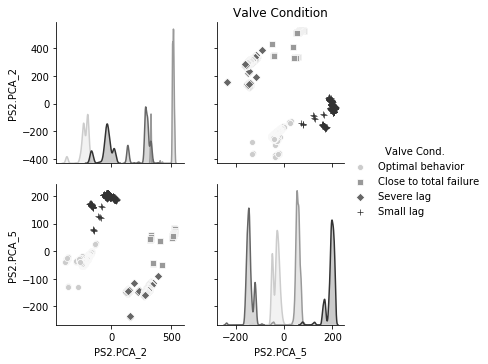

In [99]:
sns.pairplot(data = pd.concat([X2,y2.map({73:'Close to total failure',80:'Severe lag',
                                          90:'Small lag',100:'Optimal behavior'})],axis=1),
             vars=['PS2.PCA_2','PS2.PCA_5'],hue='Valve Cond.',
             markers=['o','s','D','+'],palette='binary')
plt.title('Valve Condition')

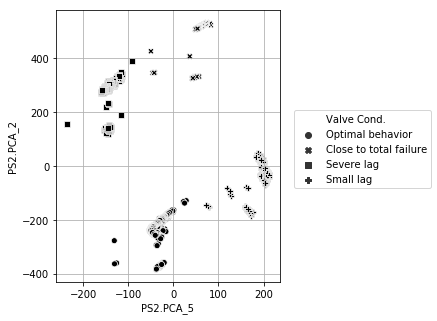

In [191]:
plt.figure(figsize=(4,5))
sns.scatterplot(x=X2['PS2.PCA_5'],y=X2['PS2.PCA_2'],style=y2.map({73:'Close to total failure',80:'Severe lag',
                                          90:'Small lag',100:'Optimal behavior'}),color='k')
plt.legend(loc=1,bbox_to_anchor = (1.7,0.65))
plt.grid()

## 5.3 Internal Pump Leakage

In [56]:
X3 = selected_features_3.drop(columns=['SE.VAR()','SE.FOURIER_2','EPS1.PCA_2'])
y3 = profile.iloc[:,2]
X_train, X_test, y_train, y_test = train_test_split(X3,y3,test_size=0.25,shuffle=True)

__Random Forest__

In [207]:
f1_train = []
f1_test = []
f1_cv = []
n=X3.shape[1]
for i in range(n):
    clf_rf = RandomForestClassifier()
    clf_rf.fit(X_train.iloc[:,:i+1],y_train)
    pred_train = clf_rf.predict(X_train.iloc[:,:i+1])
    pred_rf = clf_rf.predict(X_test.iloc[:,:i+1])
    f1_train.append(f1_score(y_train,pred_train,average='weighted'))
    f1_test.append(f1_score(y_test,pred_rf,average='weighted'))
    X_3, y_3 = X_y_shuffle(X3.iloc[:,:i+1],y3)
    scores = cross_val_score(clf_rf, X_3, y_3, cv=10)
    f1_cv.append(scores.mean())

Text(0.5, 1.0, 'Internal Pump Leakage Classification Score')

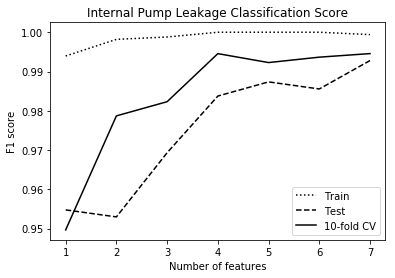

In [223]:
plt.plot(np.arange(n)+1,f1_train,linestyle=':',color='k')
plt.plot(np.arange(n)+1,f1_test,linestyle='--',color='k')
plt.plot(np.arange(n)+1,f1_cv,linestyle='-',color='k')
plt.xlabel('Number of features')
plt.ylabel('F1 score')
plt.legend(['Train','Test','10-fold CV'])
plt.title('Internal Pump Leakage Classification Score')

In [57]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train,y_train)
pred_train = clf_rf.predict(X_train)
print(classification_report(y_train,pred_train,digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       903
           1     1.0000    1.0000    1.0000       367
           2     1.0000    1.0000    1.0000       383

   micro avg     1.0000    1.0000    1.0000      1653
   macro avg     1.0000    1.0000    1.0000      1653
weighted avg     1.0000    1.0000    1.0000      1653



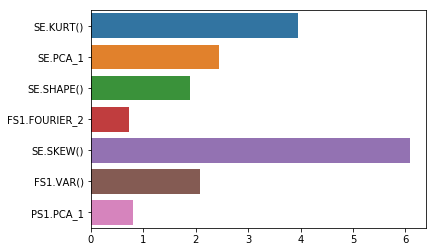

In [59]:
sns.barplot(y=X_train.columns,x=18*clf_rf.feature_importances_)

In [210]:
#clf_rf = RandomForestClassifier()
#clf_rf.fit(X_train,y_train)
pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test,pred_rf,digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9934    0.9967       301
           1     0.9615    0.9843    0.9728       127
           2     0.9837    0.9758    0.9798       124

   micro avg     0.9873    0.9873    0.9873       552
   macro avg     0.9818    0.9845    0.9831       552
weighted avg     0.9875    0.9873    0.9874       552



In [211]:
clf_rf = RandomForestClassifier()
X_3, y_3 = X_y_shuffle(X3,y3)
scores = cross_val_score(clf_rf, X_3, y_3, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 1.00 (+/- 0.01)


In [106]:
X3.head(2)

SE.KURT()   SE.PCA_1     SE.SHAPE()  FS1.FOURIER_2      SE.SKEW()  \
0  1.926535e+07 -35.176522  227625.024753     646.597199  279002.242790   
1  1.952940e+07 -37.497682  228684.915159     652.282218  281752.514382   

      SE.VAR()  SE.FOURIER_2   EPS1.PCA_2  PS1.PCA_1  PS1.PCA_2  
0  4054.887162    549.325209  3183.191459 -58.352485  80.552298  
1  4080.428991    562.590366  2893.156220 -69.870952  70.686168

In [107]:
y3.value_counts()

0    1221
1     492
2     492
Name: Pump Leakage, dtype: int64

Text(0.5, 1.0, 'Valve Condition')

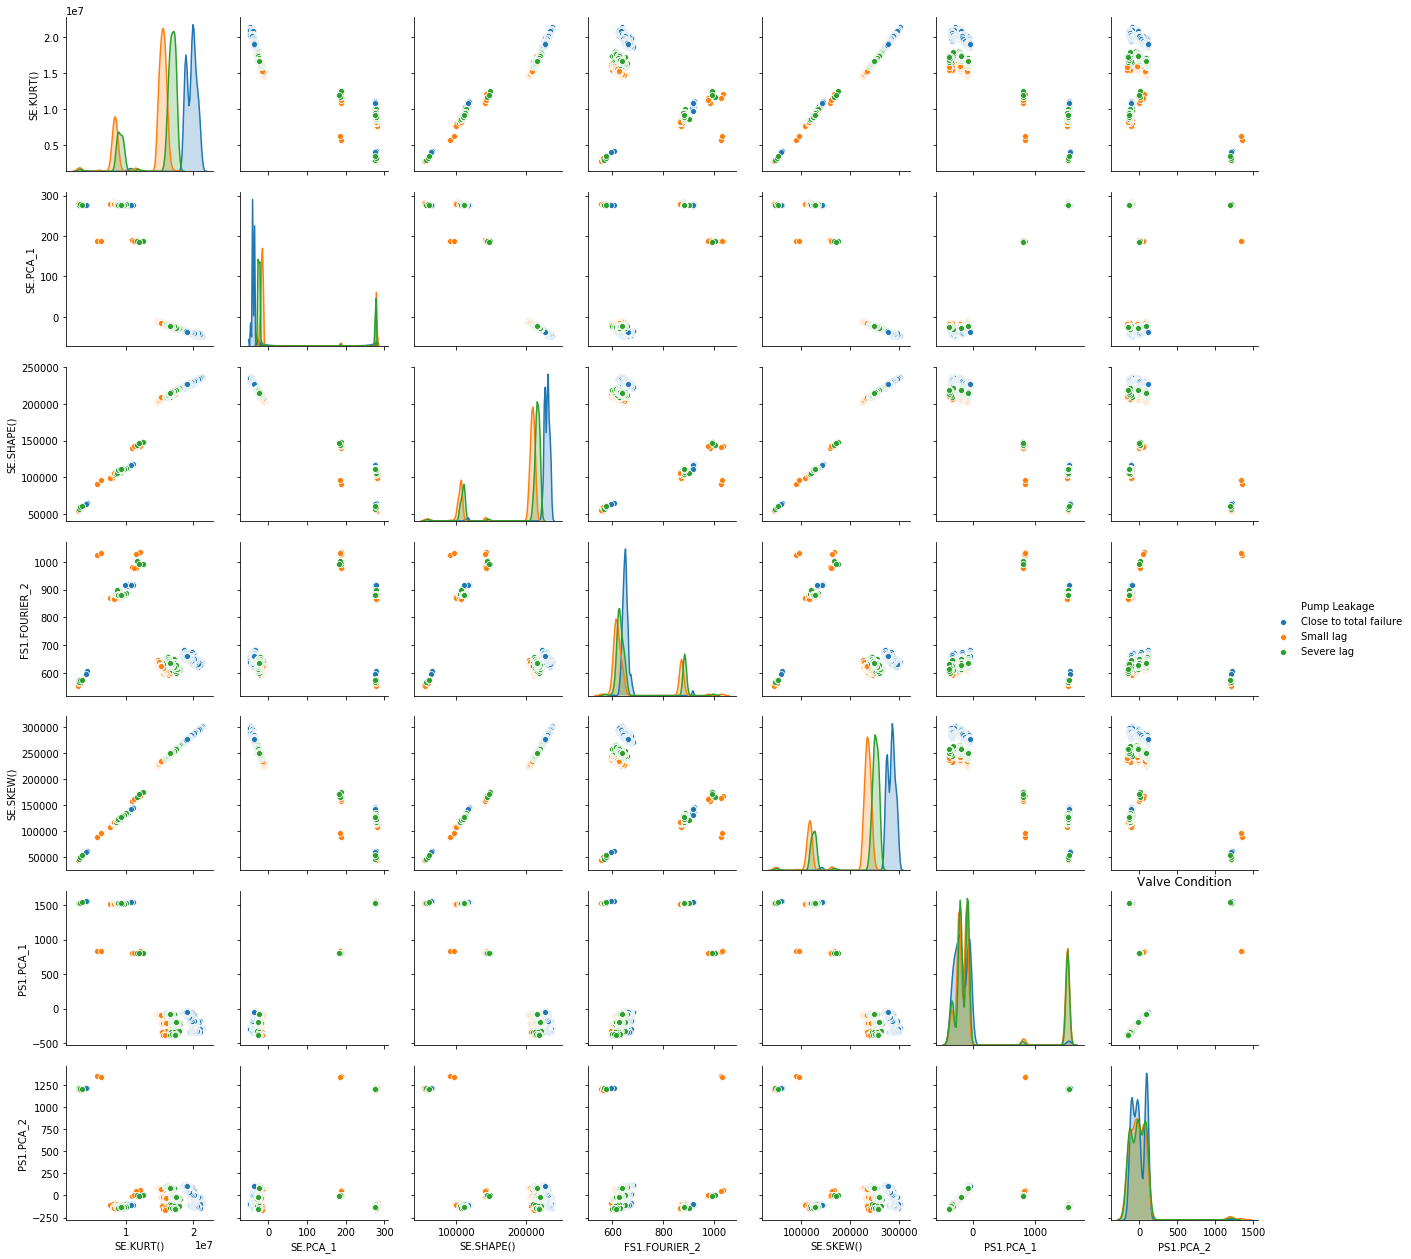

In [224]:
sns.pairplot(data = pd.concat([X3,y3.map({0:'Close to total failure',1:'Severe lag',
                                          2:'Small lag'})],axis=1),
             hue='Pump Leakage')
plt.title('Valve Condition')

__LightGBM__

## 5.4 Hydraulic Accumulator

In [532]:
X4 = selected_features_4
y4 = profile.iloc[:,3]
X_train, X_test, y_train, y_test = train_test_split(X4,y4,test_size=0.25,shuffle=True)

In [489]:
X4.columns

Index(['FS1.PCA_9', 'PS1.dSHAPE()', 'FS1.PCA_7', 'PS1.dCREST()',
       'FS1.FOURIER_7', 'PS6.dSHAPE()', 'PS3.PCA_11', 'FS1.PCA_8',
       'PS3.PCA_15', 'TS1.CLEAR()', 'PS4.dSHAPE()', 'EPS1.PCA_6',
       'FS2.dSHAPE()', 'PS1.PCA_4', 'PS3.FOURIER_7', 'TS4.VAR()', 'FS2.PCA_1',
       'SE.PCA_1', 'FS2.FOURIER_1', 'SE.PCA_3'],
      dtype='object')

__Random Forest__

In [540]:
f1_train = []
f1_test = []
f1_cv = []
n=X4.shape[1]
for i in range(n):
    clf_rf = RandomForestClassifier(min_samples_leaf=3,n_estimators=75,max_depth=12,max_features='log2',
                                    n_jobs=-1,random_state=7)
    clf_rf.fit(X_train.iloc[:,:i+1],y_train)
    pred_train = clf_rf.predict(X_train.iloc[:,:i+1])
    pred_rf = clf_rf.predict(X_test.iloc[:,:i+1])
    f1_train.append(f1_score(y_train,pred_train,average='weighted'))
    f1_test.append(f1_score(y_test,pred_rf,average='weighted'))
    X_4, y_4 = X_y_shuffle(X4.iloc[:,:i+1],y4)
    scores = cross_val_score(clf_rf, X_4, y_4, cv=10)
    f1_cv.append(scores.mean())

Text(0.5, 1.0, 'Hydraulic Accumulator Classification Score')

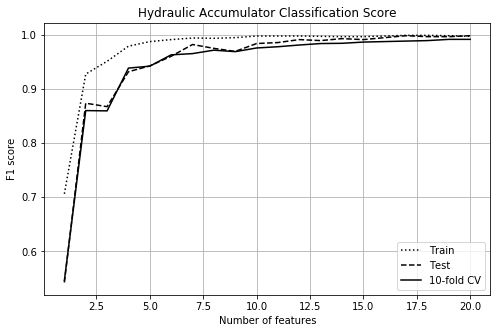

In [541]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(n)+1,f1_train,linestyle=':',color='k')
plt.plot(np.arange(n)+1,f1_test,linestyle='--',color='k')
plt.plot(np.arange(n)+1,f1_cv,linestyle='-',color='k')
plt.xlabel('Number of features')
plt.ylabel('F1 score')
plt.legend(['Train','Test','10-fold CV'])
plt.grid(True)
plt.title('Hydraulic Accumulator Classification Score')

In [545]:
f1_cv

[0.5459858168397068,
 0.8599107723396149,
 0.8593792166088182,
 0.9383493356738137,
 0.9419088027721804,
 0.9628189173255585,
 0.9650835312694894,
 0.9714537928864304,
 0.96870961107204,
 0.9754948846220195,
 0.9777864640103731,
 0.9809685096686994,
 0.9836708737183122,
 0.9841170783675528,
 0.9863795218064668,
 0.9873095215979466,
 0.9882248965455798,
 0.9891070220102479,
 0.9913839765547546,
 0.9913986013986014]

In [539]:
clf_rf = RandomForestClassifier(min_samples_leaf=3,n_estimators=75,max_depth=12,max_features='log2',
                                    n_jobs=-1,random_state=7)
clf_rf.fit(X_train,y_train)
pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test,pred_rf,digits=4))

              precision    recall  f1-score   support

          90     0.9952    1.0000    0.9976       208
         100     1.0000    1.0000    1.0000        85
         115     1.0000    1.0000    1.0000       101
         130     1.0000    0.9937    0.9968       158

   micro avg     0.9982    0.9982    0.9982       552
   macro avg     0.9988    0.9984    0.9986       552
weighted avg     0.9982    0.9982    0.9982       552



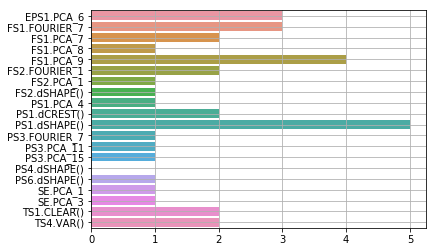

In [493]:
sns.barplot(y=X_train.columns,x=np.round(37*clf_rf.feature_importances_),order=X_train.columns.sort_values())
plt.grid(True)

In [498]:
import optuna

def objective(trial):
    
    par1 = trial.suggest_int('min_samples_leaf',1,50)
    
    par2 = int(trial.suggest_discrete_uniform('n_estimators',25,100,5))
    
    par3 = trial.suggest_int('max_depth',7,15)
    
    par4 = trial.suggest_categorical('max_features',['sqrt','log2'])
    
    clf = RandomForestClassifier(n_jobs=-1,random_state=7,min_samples_leaf=par1,n_estimators=par2,
                                 max_depth=par3,max_features=par4)
    
    score = cross_val_score(clf, X_4, y_4,n_jobs=-1,cv=5,scoring='f1_weighted')
    f1 = score.mean()
    
    return 1-f1

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

print(study.best_trial)

[I 2019-01-29 22:03:33,996] Finished a trial resulted in value: 0.017695119383647984. Current best value is 0.017695119383647984 with parameters: {'min_samples_leaf': 9, 'n_estimators': 95.0, 'max_depth': 12, 'max_features': 'sqrt'}.
[I 2019-01-29 22:03:34,428] Finished a trial resulted in value: 0.01679179719200108. Current best value is 0.01679179719200108 with parameters: {'min_samples_leaf': 8, 'n_estimators': 60.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:03:34,917] Finished a trial resulted in value: 0.036338514309106396. Current best value is 0.01679179719200108 with parameters: {'min_samples_leaf': 8, 'n_estimators': 60.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:03:35,399] Finished a trial resulted in value: 0.021343233403081308. Current best value is 0.01679179719200108 with parameters: {'min_samples_leaf': 8, 'n_estimators': 60.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:03:35,774] Finished a trial resulted in value: 0.04646

[I 2019-01-29 22:04:04,309] Finished a trial resulted in value: 0.019986293093948282. Current best value is 0.010018345683642016 with parameters: {'min_samples_leaf': 3, 'n_estimators': 50.0, 'max_depth': 15, 'max_features': 'log2'}.
[I 2019-01-29 22:04:04,648] Finished a trial resulted in value: 0.01544286183918897. Current best value is 0.010018345683642016 with parameters: {'min_samples_leaf': 3, 'n_estimators': 50.0, 'max_depth': 15, 'max_features': 'log2'}.
[I 2019-01-29 22:04:05,002] Finished a trial resulted in value: 0.012759170841943779. Current best value is 0.010018345683642016 with parameters: {'min_samples_leaf': 3, 'n_estimators': 50.0, 'max_depth': 15, 'max_features': 'log2'}.
[I 2019-01-29 22:04:05,515] Finished a trial resulted in value: 0.011344925741953227. Current best value is 0.010018345683642016 with parameters: {'min_samples_leaf': 3, 'n_estimators': 50.0, 'max_depth': 15, 'max_features': 'log2'}.
[I 2019-01-29 22:04:05,890] Finished a trial resulted in value: 0

[I 2019-01-29 22:04:20,425] Finished a trial resulted in value: 0.011374084004455276. Current best value is 0.010006729924939228 with parameters: {'min_samples_leaf': 2, 'n_estimators': 100.0, 'max_depth': 14, 'max_features': 'log2'}.
[I 2019-01-29 22:04:20,931] Finished a trial resulted in value: 0.04321583034759624. Current best value is 0.010006729924939228 with parameters: {'min_samples_leaf': 2, 'n_estimators': 100.0, 'max_depth': 14, 'max_features': 'log2'}.
[I 2019-01-29 22:04:21,398] Finished a trial resulted in value: 0.03323401779659052. Current best value is 0.010006729924939228 with parameters: {'min_samples_leaf': 2, 'n_estimators': 100.0, 'max_depth': 14, 'max_features': 'log2'}.
[I 2019-01-29 22:04:21,728] Finished a trial resulted in value: 0.03978390363397322. Current best value is 0.010006729924939228 with parameters: {'min_samples_leaf': 2, 'n_estimators': 100.0, 'max_depth': 14, 'max_features': 'log2'}.
[I 2019-01-29 22:04:22,210] Finished a trial resulted in value:

[I 2019-01-29 22:04:55,332] Finished a trial resulted in value: 0.019474044054034634. Current best value is 0.009561802685088439 with parameters: {'min_samples_leaf': 1, 'n_estimators': 90.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:04:55,893] Finished a trial resulted in value: 0.021345994228505694. Current best value is 0.009561802685088439 with parameters: {'min_samples_leaf': 1, 'n_estimators': 90.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:04:56,374] Finished a trial resulted in value: 0.039057477073114244. Current best value is 0.009561802685088439 with parameters: {'min_samples_leaf': 1, 'n_estimators': 90.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:04:56,859] Finished a trial resulted in value: 0.020434599176970658. Current best value is 0.009561802685088439 with parameters: {'min_samples_leaf': 1, 'n_estimators': 90.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:04:57,335] Finished a trial resulted in value: 

[I 2019-01-29 22:05:32,104] Finished a trial resulted in value: 0.05190274876097867. Current best value is 0.009561802685088439 with parameters: {'min_samples_leaf': 1, 'n_estimators': 90.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:05:32,625] Finished a trial resulted in value: 0.01726914762865861. Current best value is 0.009561802685088439 with parameters: {'min_samples_leaf': 1, 'n_estimators': 90.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:05:33,140] Finished a trial resulted in value: 0.02457403907212774. Current best value is 0.009561802685088439 with parameters: {'min_samples_leaf': 1, 'n_estimators': 90.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:05:33,661] Finished a trial resulted in value: 0.027719808152184. Current best value is 0.009561802685088439 with parameters: {'min_samples_leaf': 1, 'n_estimators': 90.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:05:34,151] Finished a trial resulted in value: 0.0217

[I 2019-01-29 22:06:08,805] Finished a trial resulted in value: 0.010004423030206766. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:06:09,333] Finished a trial resulted in value: 0.0409697051279212. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:06:09,780] Finished a trial resulted in value: 0.011367995952184629. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:06:10,322] Finished a trial resulted in value: 0.011807140643128933. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:06:10,834] Finished a trial resulted in value: 0.

[I 2019-01-29 22:06:44,743] Finished a trial resulted in value: 0.015426784627333268. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:06:45,382] Finished a trial resulted in value: 0.0387183709853719. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:06:45,752] Finished a trial resulted in value: 0.011833816110682016. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:06:46,263] Finished a trial resulted in value: 0.030843883289189633. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:06:46,906] Finished a trial resulted in value: 0.

[I 2019-01-29 22:07:24,386] Finished a trial resulted in value: 0.011802789008512504. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:07:24,979] Finished a trial resulted in value: 0.018137982132965136. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:07:25,387] Finished a trial resulted in value: 0.03673878479597881. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:07:26,113] Finished a trial resulted in value: 0.009561802685088439. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:07:26,626] Finished a trial resulted in value: 0

[I 2019-01-29 22:08:04,400] Finished a trial resulted in value: 0.01090185843462288. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:08:04,995] Finished a trial resulted in value: 0.011367597573212485. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:08:05,572] Finished a trial resulted in value: 0.010910576112846626. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:08:06,125] Finished a trial resulted in value: 0.012726799601976091. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:08:06,699] Finished a trial resulted in value: 0

[I 2019-01-29 22:08:45,286] Finished a trial resulted in value: 0.012257392240466958. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:08:45,890] Finished a trial resulted in value: 0.010006209754447104. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:08:46,682] Finished a trial resulted in value: 0.009561802685088439. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:08:47,251] Finished a trial resulted in value: 0.014982979114006034. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:08:47,867] Finished a trial resulted in value: 

[I 2019-01-29 22:09:27,771] Finished a trial resulted in value: 0.01316581914415893. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:09:28,351] Finished a trial resulted in value: 0.03875286784036991. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:09:28,965] Finished a trial resulted in value: 0.016328313880813683. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:09:29,519] Finished a trial resulted in value: 0.01316833791326677. Current best value is 0.009553307671959055 with parameters: {'min_samples_leaf': 1, 'n_estimators': 95.0, 'max_depth': 11, 'max_features': 'log2'}.
[I 2019-01-29 22:09:30,138] Finished a trial resulted in value: 0.0

[I 2019-01-29 22:10:10,234] Finished a trial resulted in value: 0.0409697051279212. Current best value is 0.009552912092880339 with parameters: {'min_samples_leaf': 2, 'n_estimators': 90.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:10:10,878] Finished a trial resulted in value: 0.01769101484438651. Current best value is 0.009552912092880339 with parameters: {'min_samples_leaf': 2, 'n_estimators': 90.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:10:11,500] Finished a trial resulted in value: 0.012286735139952043. Current best value is 0.009552912092880339 with parameters: {'min_samples_leaf': 2, 'n_estimators': 90.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:10:12,117] Finished a trial resulted in value: 0.009561802685088439. Current best value is 0.009552912092880339 with parameters: {'min_samples_leaf': 2, 'n_estimators': 90.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:10:12,717] Finished a trial resulted in value: 0.0

[I 2019-01-29 22:10:55,098] Finished a trial resulted in value: 0.011367597573212485. Current best value is 0.009552912092880339 with parameters: {'min_samples_leaf': 2, 'n_estimators': 90.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:10:55,805] Finished a trial resulted in value: 0.012281188523034059. Current best value is 0.009552912092880339 with parameters: {'min_samples_leaf': 2, 'n_estimators': 90.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:10:56,445] Finished a trial resulted in value: 0.01316581914415893. Current best value is 0.009552912092880339 with parameters: {'min_samples_leaf': 2, 'n_estimators': 90.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:10:57,047] Finished a trial resulted in value: 0.011367995952184629. Current best value is 0.009552912092880339 with parameters: {'min_samples_leaf': 2, 'n_estimators': 90.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:10:57,689] Finished a trial resulted in value: 0

[I 2019-01-29 22:11:41,178] Finished a trial resulted in value: 0.010907400612969242. Current best value is 0.009552912092880339 with parameters: {'min_samples_leaf': 2, 'n_estimators': 90.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:11:41,826] Finished a trial resulted in value: 0.014076930423991052. Current best value is 0.009552912092880339 with parameters: {'min_samples_leaf': 2, 'n_estimators': 90.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:11:42,501] Finished a trial resulted in value: 0.012269294733089575. Current best value is 0.009552912092880339 with parameters: {'min_samples_leaf': 2, 'n_estimators': 90.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:11:43,130] Finished a trial resulted in value: 0.015434838674440954. Current best value is 0.009552912092880339 with parameters: {'min_samples_leaf': 2, 'n_estimators': 90.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:11:43,810] Finished a trial resulted in value: 

[I 2019-01-29 22:12:27,263] Finished a trial resulted in value: 0.015938545799020654. Current best value is 0.00955016311016288 with parameters: {'min_samples_leaf': 2, 'n_estimators': 75.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:12:27,949] Finished a trial resulted in value: 0.014084609213838584. Current best value is 0.00955016311016288 with parameters: {'min_samples_leaf': 2, 'n_estimators': 75.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:12:28,590] Finished a trial resulted in value: 0.009993794673291867. Current best value is 0.00955016311016288 with parameters: {'min_samples_leaf': 2, 'n_estimators': 75.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:12:29,275] Finished a trial resulted in value: 0.03226156182651985. Current best value is 0.00955016311016288 with parameters: {'min_samples_leaf': 2, 'n_estimators': 75.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:12:29,950] Finished a trial resulted in value: 0.019

FrozenTrial(trial_id=884, state=<TrialState.COMPLETE: 1>, value=0.00955016311016288, datetime_start=datetime.datetime(2019, 1, 29, 22, 11, 47, 38743), datetime_complete=datetime.datetime(2019, 1, 29, 22, 11, 47, 585668), params={'min_samples_leaf': 2, 'n_estimators': 75.0, 'max_depth': 12, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, params_in_internal_repr={'min_samples_leaf': 2, 'n_estimators': 75.0, 'max_depth': 12, 'max_features': 1})


In [72]:
X_train.columns.sort_values()

Index(['EPS1.PCA_6', 'FS1.FOURIER_7', 'FS1.PCA_7', 'FS1.PCA_8', 'FS1.PCA_9',
       'FS2.FOURIER_1', 'FS2.PCA_1', 'FS2.dSHAPE()', 'PS1.PCA_4',
       'PS1.dCREST()', 'PS1.dSHAPE()', 'PS3.FOURIER_7', 'PS3.PCA_11',
       'PS3.PCA_15', 'PS4.dSHAPE()', 'PS6.dSHAPE()', 'SE.PCA_1', 'SE.PCA_3',
       'TS1.CLEAR()', 'TS4.VAR()'],
      dtype='object')

In [110]:
from sklearn.tree import export_graphviz

for i in range(5):
    output='tree'+str(i)+'.dot'
    true_output='tree'+str(i)+'.png'
    # Export as dot file
    export_graphviz(clf_rf.estimators_[i], out_file=output, 
                    feature_names = X4.columns,
                    class_names = list(hydraulic_accumulator.values()),
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import run
    run(['dot', '-Tpng', output, '-o', true_output, '-Gdpi=200'])


In [ ]:
clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1)
X_4, y_4 = X_y_shuffle(X4,y4)
scores = cross_val_score(clf_rf, X_4, y_4, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

__LightGBM__

In [235]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(y_train)
y_train=le.transform(y_train)
y_test=le.transform(y_test)

In [236]:
train_data=lgb.Dataset(X_train, y_train)
test_data=lgb.Dataset(X_test, y_test, reference=train_data)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'num_leaves': 50,
    'num_boost_round': 150,
    'learning_rate': 0.1,
    'min_data_in_leaf': 50,
    'max_depth': 8,
    'verbose': 0,
    'n_jobs': -1,
    'is_inbalance': True
}

model = lgb.train(params,train_data,valid_sets=test_data)

[1]	valid_0's multi_logloss: 1.24731
[2]	valid_0's multi_logloss: 1.12953
[3]	valid_0's multi_logloss: 1.03321
[4]	valid_0's multi_logloss: 0.948396
[5]	valid_0's multi_logloss: 0.874734
[6]	valid_0's multi_logloss: 0.808034
[7]	valid_0's multi_logloss: 0.748348
[8]	valid_0's multi_logloss: 0.69283
[9]	valid_0's multi_logloss: 0.643284
[10]	valid_0's multi_logloss: 0.598241
[11]	valid_0's multi_logloss: 0.558024
[12]	valid_0's multi_logloss: 0.522289
[13]	valid_0's multi_logloss: 0.488878
[14]	valid_0's multi_logloss: 0.457764
[15]	valid_0's multi_logloss: 0.429545
[16]	valid_0's multi_logloss: 0.402116
[17]	valid_0's multi_logloss: 0.376711
[18]	valid_0's multi_logloss: 0.35314
[19]	valid_0's multi_logloss: 0.332019
[20]	valid_0's multi_logloss: 0.311951
[21]	valid_0's multi_logloss: 0.294369
[22]	valid_0's multi_logloss: 0.27848
[23]	valid_0's multi_logloss: 0.262857
[24]	valid_0's multi_logloss: 0.249593
[25]	valid_0's multi_logloss: 0.237234
[26]	valid_0's multi_logloss: 0.22377
[2

In [237]:
pred_lgb = pd.DataFrame(model.predict(X_test, num_iteration=model.best_iteration)).idxmax(axis=1)
print(classification_report(y_test,pred_lgb,digits=4))

              precision    recall  f1-score   support

           0     0.9838    0.9891    0.9864       184
           1     0.9815    0.9815    0.9815       108
           2     1.0000    0.9823    0.9911       113
           3     0.9932    1.0000    0.9966       147

   micro avg     0.9891    0.9891    0.9891       552
   macro avg     0.9896    0.9882    0.9889       552
weighted avg     0.9892    0.9891    0.9891       552



### Ridge Regression

In [ ]:
X4, y4=Xy_shuffle1(ridge_selected_features_4,profile.iloc[:,3])
clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1)
scores = cross_val_score(clf_rf, X4, y4, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### Lasso Regression

In [ ]:
X4,y4=Xy_shuffle(lazo_selected_features_4,profile.iloc[:,3])
clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1)
scores = cross_val_score(clf_rf, X4, y4, cv=6)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### Greedy Forward Selection

In [ ]:
X4,y4=Xy_shuffle(gf_selected_features_4,profile.iloc[:,3])
clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1,random_state=24)
scores = cross_val_score(clf_rf, X4, y4, cv=6)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

### Backward Elimination Selection

In [ ]:
X4,y4=Xy_shuffle(be_selected_features_4,profile.iloc[:,3])
clf_rf = RandomForestClassifier(min_samples_leaf=5,n_estimators=50,n_jobs=-1)
scores = cross_val_score(clf_rf, X4, y4, cv=6)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

## 5.5 Stable Flag

In [505]:
X5 = selected_features_5
y5 = profile.iloc[:,4]
X_train, X_test, y_train, y_test = train_test_split(X5,y5,test_size=0.25,shuffle=True)

In [509]:
import optuna

def objective(trial):
    
    par1 = trial.suggest_int('min_samples_leaf',1,50)
    
    par2 = int(trial.suggest_discrete_uniform('n_estimators',25,100,5))
    
    par3 = trial.suggest_int('max_depth',7,15)
    
    par4 = trial.suggest_categorical('max_features',['sqrt','log2'])
    
    clf = RandomForestClassifier(n_jobs=-1,random_state=7,min_samples_leaf=par1,n_estimators=par2,
                                 max_depth=par3,max_features=par4)
    
    score = cross_val_score(clf, X_5, y_5,n_jobs=-1,cv=5,scoring='f1_weighted')
    f1 = score.mean()
    
    return 1-f1

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

print(study.best_trial)

[I 2019-01-29 22:19:44,340] Finished a trial resulted in value: 0.04510001827221477. Current best value is 0.04510001827221477 with parameters: {'min_samples_leaf': 26, 'n_estimators': 35.0, 'max_depth': 8, 'max_features': 'sqrt'}.
[I 2019-01-29 22:19:45,285] Finished a trial resulted in value: 0.04543036197909289. Current best value is 0.04510001827221477 with parameters: {'min_samples_leaf': 26, 'n_estimators': 35.0, 'max_depth': 8, 'max_features': 'sqrt'}.
[I 2019-01-29 22:19:46,094] Finished a trial resulted in value: 0.04723533287859083. Current best value is 0.04510001827221477 with parameters: {'min_samples_leaf': 26, 'n_estimators': 35.0, 'max_depth': 8, 'max_features': 'sqrt'}.
[I 2019-01-29 22:19:46,516] Finished a trial resulted in value: 0.04541222821837765. Current best value is 0.04510001827221477 with parameters: {'min_samples_leaf': 26, 'n_estimators': 35.0, 'max_depth': 8, 'max_features': 'sqrt'}.
[I 2019-01-29 22:19:46,872] Finished a trial resulted in value: 0.045071

[I 2019-01-29 22:20:12,871] Finished a trial resulted in value: 0.022354114838633143. Current best value is 0.020069592801940317 with parameters: {'min_samples_leaf': 1, 'n_estimators': 85.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:20:13,366] Finished a trial resulted in value: 0.027820938197909983. Current best value is 0.020069592801940317 with parameters: {'min_samples_leaf': 1, 'n_estimators': 85.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:20:13,732] Finished a trial resulted in value: 0.021449255149703306. Current best value is 0.020069592801940317 with parameters: {'min_samples_leaf': 1, 'n_estimators': 85.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:20:14,211] Finished a trial resulted in value: 0.03874450077971525. Current best value is 0.020069592801940317 with parameters: {'min_samples_leaf': 1, 'n_estimators': 85.0, 'max_depth': 12, 'max_features': 'log2'}.
[I 2019-01-29 22:20:14,682] Finished a trial resulted in value: 0

[I 2019-01-29 22:20:40,093] Finished a trial resulted in value: 0.02648943583607788. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:20:40,477] Finished a trial resulted in value: 0.033785876427225525. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:20:40,792] Finished a trial resulted in value: 0.04378595298698307. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:20:41,230] Finished a trial resulted in value: 0.023274894580021188. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:20:41,699] Finished a trial resulted in value: 0.02826785

[I 2019-01-29 22:21:06,514] Finished a trial resulted in value: 0.02736749350364165. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:21:06,853] Finished a trial resulted in value: 0.020518053891897536. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:21:07,345] Finished a trial resulted in value: 0.022354114838633143. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:21:07,662] Finished a trial resulted in value: 0.023260505115864083. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:21:07,998] Finished a trial resulted in value: 0.0455321

[I 2019-01-29 22:21:34,570] Finished a trial resulted in value: 0.02872461067913279. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:21:35,079] Finished a trial resulted in value: 0.03190835705452666. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:21:35,493] Finished a trial resulted in value: 0.025563975118994442. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:21:36,013] Finished a trial resulted in value: 0.021447289396479663. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:21:36,547] Finished a trial resulted in value: 0.02509803

[I 2019-01-29 22:22:03,871] Finished a trial resulted in value: 0.02007310240114213. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:22:04,212] Finished a trial resulted in value: 0.02601358431150591. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:22:04,604] Finished a trial resulted in value: 0.029636254946824314. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:22:05,187] Finished a trial resulted in value: 0.038755943113079505. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:22:05,598] Finished a trial resulted in value: 0.04198165

[I 2019-01-29 22:22:34,175] Finished a trial resulted in value: 0.027820551987670306. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:22:34,545] Finished a trial resulted in value: 0.020984268779768334. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:22:34,949] Finished a trial resulted in value: 0.02735316562678647. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:22:35,367] Finished a trial resulted in value: 0.022352332792757834. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:22:35,773] Finished a trial resulted in value: 0.0255636

[I 2019-01-29 22:23:04,557] Finished a trial resulted in value: 0.02098304026183251. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:23:04,963] Finished a trial resulted in value: 0.04551682937869006. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:23:05,516] Finished a trial resulted in value: 0.022355475851461692. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:23:05,966] Finished a trial resulted in value: 0.025533460462493274. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:23:06,517] Finished a trial resulted in value: 0.02282060

[I 2019-01-29 22:23:36,822] Finished a trial resulted in value: 0.025563797134216415. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:23:37,372] Finished a trial resulted in value: 0.04366574042086435. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:23:37,963] Finished a trial resulted in value: 0.028720091243602086. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:23:38,566] Finished a trial resulted in value: 0.035563848563323175. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:23:38,989] Finished a trial resulted in value: 0.0291742

[I 2019-01-29 22:24:09,863] Finished a trial resulted in value: 0.020985098667675728. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:24:10,347] Finished a trial resulted in value: 0.02601875881320126. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:24:10,780] Finished a trial resulted in value: 0.022363363103299783. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:24:11,260] Finished a trial resulted in value: 0.02505988166454798. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:24:11,711] Finished a trial resulted in value: 0.02144728

[I 2019-01-29 22:24:45,242] Finished a trial resulted in value: 0.02144385775117852. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:24:45,892] Finished a trial resulted in value: 0.025993075929913845. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:24:46,351] Finished a trial resulted in value: 0.02143347494202419. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:24:46,831] Finished a trial resulted in value: 0.022345032257552355. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:24:47,274] Finished a trial resulted in value: 0.02872461

[I 2019-01-29 22:25:20,476] Finished a trial resulted in value: 0.02828107612486619. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:25:20,955] Finished a trial resulted in value: 0.02508405886748777. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:25:21,441] Finished a trial resulted in value: 0.021902414404545212. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:25:21,934] Finished a trial resulted in value: 0.04504337529134683. Current best value is 0.02006576999807186 with parameters: {'min_samples_leaf': 1, 'n_estimators': 55.0, 'max_depth': 9, 'max_features': 'log2'}.
[I 2019-01-29 22:25:22,445] Finished a trial resulted in value: 0.026029159

[I 2019-01-29 22:25:56,662] Finished a trial resulted in value: 0.02006037259954707. Current best value is 0.02006037259954707 with parameters: {'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}.
[I 2019-01-29 22:25:57,144] Finished a trial resulted in value: 0.021915215755097583. Current best value is 0.02006037259954707 with parameters: {'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}.
[I 2019-01-29 22:25:57,663] Finished a trial resulted in value: 0.045517724946063765. Current best value is 0.02006037259954707 with parameters: {'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}.
[I 2019-01-29 22:25:58,139] Finished a trial resulted in value: 0.02602915908255421. Current best value is 0.02006037259954707 with parameters: {'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}.
[I 2019-01-29 22:25:58,637] Finished a trial resulted in value: 0.0251

[I 2019-01-29 22:26:32,581] Finished a trial resulted in value: 0.0405501829959547. Current best value is 0.02006037259954707 with parameters: {'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}.
[I 2019-01-29 22:26:33,105] Finished a trial resulted in value: 0.022829946641190757. Current best value is 0.02006037259954707 with parameters: {'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}.
[I 2019-01-29 22:26:33,629] Finished a trial resulted in value: 0.021915215755097583. Current best value is 0.02006037259954707 with parameters: {'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}.
[I 2019-01-29 22:26:34,140] Finished a trial resulted in value: 0.02097497062347442. Current best value is 0.02006037259954707 with parameters: {'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}.
[I 2019-01-29 22:26:34,670] Finished a trial resulted in value: 0.02145

[I 2019-01-29 22:27:09,472] Finished a trial resulted in value: 0.02508958382720028. Current best value is 0.02006037259954707 with parameters: {'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}.
[I 2019-01-29 22:27:09,982] Finished a trial resulted in value: 0.02051093715007757. Current best value is 0.02006037259954707 with parameters: {'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}.
[I 2019-01-29 22:27:10,510] Finished a trial resulted in value: 0.025103586735925054. Current best value is 0.02006037259954707 with parameters: {'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}.
[I 2019-01-29 22:27:11,058] Finished a trial resulted in value: 0.020984268779768334. Current best value is 0.02006037259954707 with parameters: {'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}.
[I 2019-01-29 22:27:11,588] Finished a trial resulted in value: 0.0223

FrozenTrial(trial_id=799, state=<TrialState.COMPLETE: 1>, value=0.02006037259954707, datetime_start=datetime.datetime(2019, 1, 29, 22, 25, 34, 582893), datetime_complete=datetime.datetime(2019, 1, 29, 22, 25, 35, 237), params={'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, params_in_internal_repr={'min_samples_leaf': 1, 'n_estimators': 50.0, 'max_depth': 10, 'max_features': 1})


### Random Forest

In [530]:
f1_train = []
f1_test = []
f1_cv = []
n=X5.shape[1]
for i in range(n):
    clf_rf = RandomForestClassifier(n_jobs=-1,random_state=7,min_samples_leaf=3,n_estimators=50,max_depth=10,
                                   max_features='log2')
    clf_rf.fit(X_train.iloc[:,:i+1],y_train)
    pred_train = clf_rf.predict(X_train.iloc[:,:i+1])
    pred_rf = clf_rf.predict(X_test.iloc[:,:i+1])
    f1_train.append(f1_score(y_train,pred_train,average='weighted'))
    f1_test.append(f1_score(y_test,pred_rf,average='weighted'))
    X_5, y_5 = X_y_shuffle(X5.iloc[:,:i+1],y5)
    scores = cross_val_score(clf_rf, X_5, y_5, cv=10)
    f1_cv.append(scores.mean())

Text(0.5, 1.0, 'Stable Flag Classification Score')

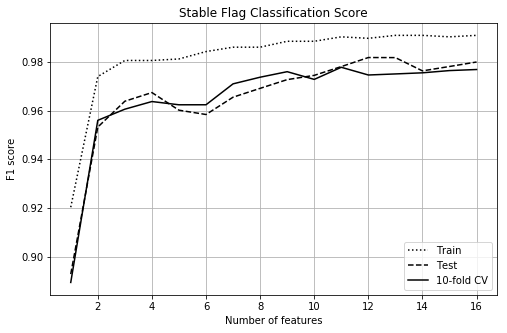

In [531]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(n)+1,f1_train,linestyle=':',color='k')
plt.plot(np.arange(n)+1,f1_test,linestyle='--',color='k')
plt.plot(np.arange(n)+1,f1_cv,linestyle='-',color='k')
plt.xlabel('Number of features')
plt.ylabel('F1 score')
plt.legend(['Train','Test','10-fold CV'])
plt.grid(True)
plt.title('Stable Flag Classification Score')

In [521]:
clf_rf = RandomForestClassifier(n_jobs=-1,random_state=7,min_samples_leaf=5,n_estimators=50,max_depth=10,
                                max_features='log2')
clf_rf.fit(X_train,y_train)
pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test,pred_rf,digits=4))

              precision    recall  f1-score   support

           0     0.9771    0.9974    0.9871       385
           1     0.9937    0.9461    0.9693       167

   micro avg     0.9819    0.9819    0.9819       552
   macro avg     0.9854    0.9718    0.9782       552
weighted avg     0.9821    0.9819    0.9818       552



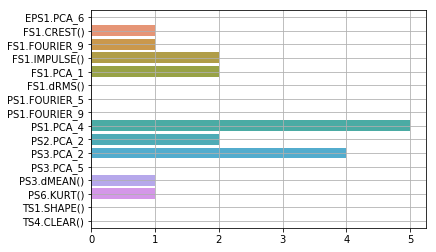

In [77]:
sns.barplot(y=X_train.columns,x=np.round(20*clf_rf.feature_importances_),order=X_train.columns.sort_values())
plt.grid(True)

In [81]:
(20*clf_rf.feature_importances_)

array([4.79044985, 2.36760091, 1.66136897, 1.31512443, 3.93993825,
       0.56951223, 0.32420374, 0.45062905, 0.59956646, 0.71153799,
       0.27499753, 0.37879881, 0.25080025, 1.50418886, 0.44270164,
       0.41858103])

In [ ]:
clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1)
X_5, y_5 = X_y_shuffle(X5,y5)
scores = cross_val_score(clf_rf, X_5, y_5, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### LightGBM

In [67]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(y_train)
y_train=le.transform(y_train)
y_test=le.transform(y_test)

In [68]:
train_data=lgb.Dataset(X_train, y_train)
test_data=lgb.Dataset(X_test, y_test, reference=train_data)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 2,
    'metric': 'multi_logloss',
    'num_leaves': 50,
    'num_boost_round': 150,
    'learning_rate': 0.1,
    'min_data_in_leaf': 50,
    'max_depth': 8,
    'verbose': 0,
    'n_jobs': -1,
    'is_inbalance': True
}

model = lgb.train(params,train_data,valid_sets=test_data)

[1]	valid_0's multi_logloss: 0.615932
[2]	valid_0's multi_logloss: 0.550566
[3]	valid_0's multi_logloss: 0.497557
[4]	valid_0's multi_logloss: 0.453444
[5]	valid_0's multi_logloss: 0.415456
[6]	valid_0's multi_logloss: 0.38213
[7]	valid_0's multi_logloss: 0.352171
[8]	valid_0's multi_logloss: 0.327983
[9]	valid_0's multi_logloss: 0.305966
[10]	valid_0's multi_logloss: 0.285748
[11]	valid_0's multi_logloss: 0.26874
[12]	valid_0's multi_logloss: 0.252654
[13]	valid_0's multi_logloss: 0.238878
[14]	valid_0's multi_logloss: 0.226169
[15]	valid_0's multi_logloss: 0.214614
[16]	valid_0's multi_logloss: 0.204831
[17]	valid_0's multi_logloss: 0.19554
[18]	valid_0's multi_logloss: 0.187706
[19]	valid_0's multi_logloss: 0.180363
[20]	valid_0's multi_logloss: 0.174838
[21]	valid_0's multi_logloss: 0.168784
[22]	valid_0's multi_logloss: 0.164169
[23]	valid_0's multi_logloss: 0.15936
[24]	valid_0's multi_logloss: 0.154383
[25]	valid_0's multi_logloss: 0.150652
[26]	valid_0's multi_logloss: 0.14672


In [69]:
pred_lgb = pd.DataFrame(model.predict(X_test, num_iteration=model.best_iteration)).idxmax(axis=1)
print(classification_report(y_test,pred_lgb,digits=4))

             precision    recall  f1-score   support

          0     0.9639    0.9775    0.9706       710
          1     0.9582    0.9338    0.9459       393

avg / total     0.9619    0.9619    0.9618      1103



Nota: Features que no se utilizaron: CE, PS1, PS4, PS5, PS6, TS2, VS1.

### Ridge Regression

In [ ]:
X5,y5=Xy_shuffle(ridge_selected_features_5,profile.iloc[:,4])
clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1)
scores = cross_val_score(clf_rf, X5, y5, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### Lasso Regression

In [ ]:
X5,y5=Xy_shuffle(lasso_selected_features_5,profile.iloc[:,4])
clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1)
scores = cross_val_score(clf_rf, X5, y5, cv=6)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### Greedy Forward Selection

In [ ]:
X5,y5=Xy_shuffle(gf_selected_features_5,profile.iloc[:,4])
clf_rf = RandomForestClassifier(min_samples_leaf=6,n_estimators=50,n_jobs=-1)
scores = cross_val_score(clf_rf, X5, y5, cv=6)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

### Backward Elimination Selection

In [ ]:
X5,y5=Xy_shuffle(be_selected_features_5,profile.iloc[:,4])
clf_rf = RandomForestClassifier(min_samples_leaf=5,n_estimators=50,n_jobs=-1,random_state=24)
scores = cross_val_score(clf_rf, X5, y5, cv=6)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))